# Research 2

By: Luis G. Leon-Vega

This brief research is about performing the preprocessing and data curation on a dataset related to Traffic Infraction in the US. Furthermore, differently to the Research 1, this research is mainly focused on applying Machine Learning techniques on the dataset, benchmarking some of the most common Machine Learning techniques, such as:

* Logistic Regression
* Random Forest
* Decision Trees
* SVM
* Bernoulli Naive Bayes
* Adaboost
* Hist_gradient_boosting

The methods quoted above will be taken from the *Sci-kit Learn* library from Google. You can find more information in [Supervised Learning - SkLearn](https://scikit-learn.org/stable/supervised_learning.html)

## Getting the dataset

It is detected dinamically if it is already downloaded to avoid reimporting it.

Site: https://catalog.data.gov/dataset/traffic-violations-56dda

In [1]:
%%bash
# Creating the data directory
mkdir data &> /dev/null || echo "Directory already exists"
cd data
# Get the dataset
ls Traffic_Violations.csv &> /dev/null || \
wget https://data.montgomerycountymd.gov/api/views/4mse-ku6q/rows.csv?accessType=DOWNLOAD -O "Traffic_Violations.csv"

Directory already exists


##  Import the common use libraries

The following cell will import all the libraries needed for common preprocessing tasks

In [120]:
# For array handling
import numpy as np
# For plotting
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
# For data management
import pandas as pd
# For colours
import seaborn as sns

# Machine Learning
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, precision_recall_curve, confusion_matrix

## Import the dataset

Warning: this dataset should be run on a machine with enough RAM. Let's estimate ~4GB free.

In [3]:
df_o = pd.read_csv('data/Traffic_Violations.csv', sep=',',header=0, low_memory=False)

In [4]:
df_o.head()

Date Of Stop Time Of Stop Agency  \
0   09/24/2013     17:11:00    MCP   
1   12/20/2012     00:41:00    MCP   
2   07/20/2012     23:12:00    MCP   
3   03/19/2012     16:10:00    MCP   
4   12/01/2014     12:52:00    MCP   

                                         SubAgency  \
0                      3rd district, Silver Spring   
1                           2nd district, Bethesda   
2                         5th district, Germantown   
3                           2nd district, Bethesda   
4  6th district, Gaithersburg / Montgomery Village   

                                         Description  \
0  DRIVING VEHICLE ON HIGHWAY WITH SUSPENDED REGI...   
1                  DRIVING WHILE IMPAIRED BY ALCOHOL   
2                       FAILURE TO STOP AT STOP SIGN   
3  DRIVER USING HANDS TO USE HANDHELD TELEPHONE W...   
4                 FAILURE STOP AND YIELD AT THRU HWY   

                                 Location   Latitude  Longitude Accident  \
0                         8804 FLOWER AVE        NaN        NaN       No   
1              NORFOLK AVE /  ST ELMO AVE  38.983578 -77.093105       No   
2         WISTERIA DR @ WARING STATION RD  39.161810 -77.253581       No   
3               CLARENDON RD @ ELM ST. N/  38.982731 -77.100755       No   
4  CHRISTOPHER AVE/MONTGOMERY VILLAGE AVE  39.162888 -77.229088       No   

  Belts  ...         Charge                 Article Contributed To Accident  \
0    No  ...      13-401(h)  Transportation Article                      No   
1    No  ...     21-902(b1)  Transportation Article                      No   
2    No  ...      21-707(a)  Transportation Article                      No   
3    No  ...  21-1124.2(d2)  Transportation Article                      No   
4    No  ...      21-403(b)  Transportation Article                      No   

       Race Gender     Driver City Driver State DL State        Arrest Type  \
0     BLACK      M     TAKOMA PARK           MD       MD  A - Marked Patrol   
1     WHITE      M         DERWOOD           MD       MD  A - Marked Patrol   
2     ASIAN      F      GERMANTOWN           MD       MD  A - Marked Patrol   
3  HISPANIC      M       ARLINGTON           VA       VA  A - Marked Patrol   
4     BLACK      F  UPPER MARLBORO           MD       MD  A - Marked Patrol   

                             Geolocation  
0                                    NaN  
1             (38.9835782, -77.09310515)  
2       (39.1618098166667, -77.25358095)  
3  (38.9827307333333, -77.1007551666667)  
4  (39.1628883333333, -77.2290883333333)  

[5 rows x 35 columns]

## First look at the data

It is possible to notice from the first row (Index 0) that we have some `NaN` values. It suggests we have to complete them before doing any analysis on the data to avoid undefined behaviours. On the other hand, it is possible to see that the description of the infraction is manually-defined, meaning that those fields are typed by a person and they may be highly variable. Let's have a look at the size and then, try to count their possible values to discard or confirm this hypothesis.

In [5]:
print("Shape of the dataset:", df_o.shape)

Shape of the dataset: (1087110, 35)


In [6]:
df_o["Description"].value_counts().shape

(11219,)

From 1 million registers, there are 11K possible classes for the description, which is really complex to manage. It is possible to discard some registers with a sort of data search with keyword matching. For example:

* "DRIVING WHILE IMPAIRED BY ALCOHOL" can be searched as ["DRIVING", "ALCOHOL"]
* "DRIVER USING HANDS TO USE HANDHELD TELEPHONE" can be searched as ["DRIVING", "TELEPHONE"]

To do so, it is possible to use the following command:

```python
pd.Series('account lock email').str.contains('account|lock', case=False)
```

where the first argument can be a regular expression (RegEx).

Nevertheless, in the past `.head()`, it was not possible to see all the columns. Below, they are listed.

In [7]:
df_o.columns

Index(['Date Of Stop', 'Time Of Stop', 'Agency', 'SubAgency', 'Description',
       'Location', 'Latitude', 'Longitude', 'Accident', 'Belts',
       'Personal Injury', 'Property Damage', 'Fatal', 'Commercial License',
       'HAZMAT', 'Commercial Vehicle', 'Alcohol', 'Work Zone', 'State',
       'VehicleType', 'Year', 'Make', 'Model', 'Color', 'Violation Type',
       'Charge', 'Article', 'Contributed To Accident', 'Race', 'Gender',
       'Driver City', 'Driver State', 'DL State', 'Arrest Type',
       'Geolocation'],
      dtype='object')

At a simple glance, considering that the purpose of our Machine Learning prediction goal is to predict the influence of several factors to have an accident or not, there are some of the columns which may not contribute to the model. The analysis of each label is carried out below:

GP attributes:

* Date of Stop: It may work for considering the period of the year
* Time of Stop: It may work for considering the period of the day: tireness of the people
* Agency, SubAgency: It may for for considering the relative location instead of an exact one.
* Description: Indeed important, since it summarises the reasons of the accident, if apply.
* Location: It may also work for relative location
* Latitude, longitude, geolocation: They offer too much info, which may be really sparse.
* Accident: It is actually the ground truth
* Contributed to Accident: It may also work as ground truth
* State: Works for relative place analysis.

Factors: the following attributes work as "accident factors"

* Belts
* Commercial Licence
* Hazardous Materials (HAZMAT)
* Commercial Vehicle
* Alcohol
* Work Zone

Vehicle attributes: It may contribute as possible factors

* VehicleType
* Year (model year)
* Make (Maker): is the manufacturer
* Model: is the model of the car. For example: Duster, Civic, Rav4...
* Color

Consequences: they may contribute to the current punishments and fines, but actually they are summarised to the accident somehow. So, it may potentionally be underestimated. 

* ViolationType
* Charge
* Article
* Arrest Type

Driver attributes: they may also contribute, but these attributes are interesting for studying the distribution of the accidents respect to the characteristics of the people. However, for analysis effects, these attributes will be neglected.

* Gender
* Race
* DL State: Driver Licence State
* Driver City, Driver State: where the driver comes from.


## Data preparation and curation

As a first step, the dataset has some undefined attributes. Before proceeding with the analysis, those attributes need to be replaced with a meaningful value.

To determine which attributes have undefined values:

In [8]:
df_o.isna().any()

Date Of Stop               False
Time Of Stop               False
Agency                     False
SubAgency                  False
Description                 True
Location                    True
Latitude                    True
Longitude                   True
Accident                   False
Belts                      False
Personal Injury            False
Property Damage            False
Fatal                      False
Commercial License         False
HAZMAT                     False
Commercial Vehicle         False
Alcohol                    False
Work Zone                  False
State                       True
VehicleType                False
Year                        True
Make                        True
Model                       True
Color                       True
Violation Type             False
Charge                     False
Article                     True
Contributed To Accident    False
Race                       False
Gender                     False
Driver Cit

From the results presented above, some of the fields are going to be discarded because of their relevance to the analysis. Some of them are:

* Latitude
* Longitude
* Color
* Article
* Geolocation

Some of the columns can be also fused:

* Driver City - Driver State
* Make - Model - Year
* Location - State

In [9]:
# Discard the columns
df_cured = df_o.drop(columns=["Latitude", "Longitude", "Color", "Article", "Geolocation"])

In [10]:
# Replace the Na before fusion
df_cured["Driver City"] = df_cured["Driver City"].fillna("")
df_cured["Driver State"] = df_cured["Driver State"].fillna("")
df_cured["Make"] = df_cured["Make"].fillna("")
df_cured["Description"] = df_cured["Description"].fillna("")
df_cured["Model"] = df_cured["Model"].fillna("")
df_cured["Year"] = df_cured["Year"].fillna("")
df_cured["Location"] = df_cured["Location"].fillna("")
df_cured["State"] = df_cured["State"].fillna("")

In [11]:
# Fuse 
df_cured["Driver Origin"] = df_cured["Driver City"] + "-" + df_cured["Driver State"]
df_cured["Vehicle"] = df_cured["Make"] + " " + df_cured["Model"]
df_cured["Full Location"] = df_cured["Location"] + "-" + df_cured["State"]

In [12]:
# Replace missing data with something meaningful
df_cured["Driver Origin"] = df_cured["Driver Origin"].replace("-", "NA")
df_cured["Vehicle"] = df_cured["Vehicle"].replace(" ", "NA")
df_cured["Full Location"] = df_cured["Full Location"].replace("-", "NA")

To verify the fields, the new columns are inspected below:

In [13]:
df_cured["Driver Origin"].value_counts()

SILVER SPRING-MD     270420
GAITHERSBURG-MD      111432
GERMANTOWN-MD         88651
ROCKVILLE-MD          87783
WASHINGTON-DC         32635
                      ...  
ELIZABETH-PA              1
ROSELLE PARK-NJ           1
MILFORD-NJ                1
NAPLES-NY                 1
PERKIOMENVILLE-PA         1
Name: Driver Origin, Length: 8038, dtype: int64

In [14]:
df_cured["Vehicle"].value_counts()

HONDA ACCORD         34750
HONDA CIVIC          32114
TOYOTA CAMRY         28268
TOYOTA COROLLA       24964
TOYT 4S              18875
                     ...  
ELDO BUS                 1
SUZU X7                  1
MERC GRAND MAQUIS        1
HOND PILTO TK            1
ACUR TL 4DR              1
Name: Vehicle, Length: 32732, dtype: int64

In [15]:
df_cured["Full Location"].value_counts()

IS 370 @ IS 270-MD                         1741
W/B IS 370 @ IS 270-MD                     1714
WAYNE AVE @ DALE DR-MD                     1360
10901 WESTLAKE DRIVE-MD                    1302
RANDOLPH / COLIE-MD                        1297
                                           ... 
N/B MD 355 @ WATKINS MILL RD-MD               1
EAST VILLAGE AVE @ HARRON VALLEY WAY-NC       1
CONNECTICUT AVENUE / BEL PRE ROAD-NC          1
WEAVER ST & LOWANDER LA-MD                    1
WAYNE AVE/CLOVERFIELD-MD                      1
Name: Full Location, Length: 204971, dtype: int64

In [16]:
print("NA: ", df_cured[df_cured["Driver Origin"] == "NA"]["Driver Origin"].value_counts())
print("NA: ", df_cured[df_cured["Vehicle"] == "NA"]["Vehicle"].value_counts())
print("NA: ", df_cured[df_cured["Full Location"] == "NA"]["Full Location"].value_counts())

NA:  NA    5
Name: Driver Origin, dtype: int64
NA:  NA    45
Name: Vehicle, dtype: int64
NA:  Series([], Name: Full Location, dtype: int64)


The missing values were completed by replacing them with "NA" which means "Not Available". 

Listing the possible values, there are some observations:

1. There are typos: some data are mistyped. For example, `TOYT 4S`, `MITISHIBI SUV`, `VOLVA XC 90`, `MECURY VILLAGER`. This introduces false classes to the several attributes and put in risk the analysis quality.
2. The "Full Location" attribute has many classes. There are 204971 which corresponds to the 20% of all the instances.

For the case of the location, it is better to cure them and replace the value by a proper class.

In [17]:
df_cured["Location"] = df_cured["Location"].replace("", "NA")
df_cured["State"] = df_cured["State"].replace("", "NA")

In [18]:
print("NA: ", df_cured[df_cured["Location"] == "NA"]["Location"].value_counts())
print("NA: ", df_cured[df_cured["State"] == "NA"]["State"].value_counts())

NA:  NA    2
Name: Location, dtype: int64
NA:  NA    59
Name: State, dtype: int64


On the other hand, it is right to suspect of the vehicle characteristics. Below, they are inspected.

In [19]:
df_cured["Make"].value_counts()

TOYOTA     120298
HONDA      114053
FORD       103314
TOYT        61648
NISSAN      56612
            ...  
YOTOA           1
TOYOTAT         1
CRYN            1
JAGR            1
7BE9868         1
Name: Make, Length: 3246, dtype: int64

In [20]:
df_cured["Model"].value_counts()

4S          123141
TK           71814
ACCORD       39401
CIVIC        36408
CAMRY        35465
             ...  
CONC             1
CAY 2S           1
CTG, 4S          1
SCION A4         1
SW SX4           1
Name: Model, Length: 16046, dtype: int64

In [21]:
df_cured["Year"].value_counts()

2006.0    69227
2007.0    68321
2005.0    67587
2004.0    67045
2003.0    64744
          ...  
7007.0        1
6874.0        1
6856.0        1
2502.0        1
5237.0        1
Name: Year, Length: 285, dtype: int64

With the inspections shown above, a deeper cleaning is required for these values. For example, there are years which exceeds the 2020's, meaning that they are incorrect values. Also, for the case of the models and the brands, they may have typos. A method to discard them is required to clean the dataset.

To cure the brands and the models, another dataset with models and brands is used to have a reference. The data have to be normalised to lowercase to be compatible.

The following cells import the dataset from https://rstudio-pubs-static.s3.amazonaws.com/248952_706edc85cfa84a369dfe401a763d32fc.html.

In [22]:
%%bash
# Get the dataset
cd data
ls autos.csv &> /dev/null || \
wget https://www.kaggle.com/orgesleka/used-cars-database/download -O "autos.csv"

In [23]:
autodf_o = pd.read_csv('data/autos.csv', sep=',',header=0, low_memory=False)

In [24]:
autodf_o.columns

Index(['dateCrawled', 'name', 'seller', 'offerType', 'price', 'abtest',
       'vehicleType', 'yearOfRegistration', 'gearbox', 'powerPS', 'model',
       'kilometer', 'monthOfRegistration', 'fuelType', 'brand',
       'notRepairedDamage', 'dateCreated', 'nrOfPictures', 'postalCode',
       'lastSeen'],
      dtype='object')

To validate this dataset, the brands and models are going to be listed.

In [25]:
autodf_o["model"].value_counts()

golf               22519
andere             19908
3er                15428
polo                9880
corsa               9389
                   ...  
rangerover             5
serie_3                3
p                      1
discovery_sport        1
serie_1                1
Name: model, Length: 252, dtype: int64

In [26]:
autodf_o["brand"].value_counts()

volkswagen        59712
bmw               30335
opel              30019
mercedes_benz     26514
audi              24673
ford              19120
renault           13467
peugeot            8334
fiat               7284
seat               5227
mazda              4292
skoda              4223
smart              3918
citroen            3907
nissan             3794
toyota             3511
sonstige_autos     2974
hyundai            2740
mini               2555
volvo              2516
mitsubishi         2315
honda              2109
kia                1916
suzuki             1775
alfa_romeo         1737
porsche            1682
chevrolet          1400
chrysler           1068
dacia               688
daihatsu            612
jeep                603
land_rover          579
subaru              576
jaguar              487
trabant             449
daewoo              405
saab                396
rover               376
lancia              367
lada                166
Name: brand, dtype: int64

Regarding to the brand, they seem correct. However, there are underscores that should be replaced by spaces.

In [27]:
autodf_o["brand"] = autodf_o["brand"].str.replace("_", " ")
autodf_o["model"] = autodf_o["model"].str.replace("_", " ")

The next step is to normalise the traffic infractions dataset to have the models and brands in lowercase.

In [28]:
df_cured["Make"] = df_cured["Make"].str.lower()
df_cured["Model"] = df_cured["Model"].str.lower()

Applying a direct filter on the "Make" column will lead to the loose of more than 50K elements, since we have `TOYT` as a category. It is required to have a kind of estimator of similarity.

To do that, let's use the first 3 characters to say that's a match.

In [29]:
autodf_o["brand_initials"] = autodf_o["brand"].str[:3] 
autodf_o["model_initials"] = autodf_o["model"].str[:3] 

In [30]:
df_cured["model_initials"] = df_cured["Model"].str[:3] 
df_cured["brand_initials"] = df_cured["Make"].str[:3] 

Now, with the models and brands in their three first initials, it is possible to compare by brand and model to create fixed columns of the brands and models.

In [31]:
# Filter out data which are not in common
mask = df_cured["brand_initials"].isin(autodf_o["brand_initials"])
df_cured = df_cured[mask]
# The model will be excluded
mask = df_cured["model_initials"].isin(autodf_o["model_initials"])
df_cured = df_cured[mask]

In [32]:
df_cured["model_initials"].value_counts()

acc    43661
civ    38480
cor    34298
alt    21154
rav     9142
       ...  
leo        1
p          1
log        1
s m        1
def        1
Name: model_initials, Length: 146, dtype: int64

In [33]:
df_cured["brand_initials"].value_counts()

hon    82004
toy    58152
for    30068
nis    25652
che    17043
vol    13882
jee     8848
sub     7923
mit     6061
hyu     5621
aud     5150
chr     4568
kia     4239
mer     3718
min     1543
lan     1156
por      798
suz      578
fia      177
saa      153
jag      144
maz      119
bmw      115
sma       37
dae       30
tra       12
rov        2
lad        1
Name: brand_initials, dtype: int64

In [34]:
df_cured.shape

(277794, 35)

3/4ths of the data have been lost because of typos in the brand or in the model. It is possible to have better strategies to curate the data, but for this research purposes, it will be considered as good enough. Also, it is important to mention that increasing the number of samples will make the process slower for some methods, leading to delays when performing the benchmark.

Another aspect is that, for simplicity, the full brand is not going to be changed and the initials will be used as  the new `brand` and `model` columns.

To complete the curation, it is required to filter the `Year`.

In [35]:
df_cured["Year"]

3          1996
4          2001
5          2004
9          2005
11         1993
           ... 
1087098    2014
1087099    2009
1087100    2017
1087103    2016
1087105    2005
Name: Year, Length: 277794, dtype: object

In [36]:
df_cured["Year"] = pd.to_numeric(df_cured["Year"])
df_cured = df_cured.dropna(subset=["Year"])

mask = df_cured["Year"] > 1970
df_cured = df_cured[mask]
mask = df_cured["Year"] < 2020
df_cured = df_cured[mask]

In [37]:
df_cured["Year"].value_counts()

2012.0    17663
2010.0    16787
2005.0    16441
2007.0    16293
2006.0    15866
2013.0    15224
2003.0    15204
2008.0    15155
2011.0    14659
2004.0    13903
2009.0    13588
2002.0    12994
2014.0    12544
2001.0    11710
2000.0    11558
2015.0     9928
1999.0     9013
1998.0     7736
1997.0     6177
2016.0     4920
1996.0     4841
1995.0     4531
1994.0     3564
1993.0     2019
1992.0     1624
1991.0      964
2017.0      714
1990.0      656
1989.0      284
1988.0      280
1987.0      189
1986.0      122
1985.0       83
1984.0       71
1983.0       45
1980.0       13
1982.0       11
1976.0        8
1978.0        5
1979.0        5
2019.0        4
2018.0        2
1974.0        2
1973.0        2
1971.0        2
1981.0        1
Name: Year, dtype: int64

Now, to perform some statistics on the data, it is required to have a look at the possible violation types to see their consistency and possible utilisation on the analysis.

In [38]:
df_cured["Description"] = df_cured["Description"].str.upper()
df_cured['Description'].value_counts()

DRIVER FAILURE TO OBEY PROPERLY PLACED TRAFFIC CONTROL DEVICE INSTRUCTIONS                             20659
FAILURE TO DISPLAY REGISTRATION CARD UPON DEMAND BY POLICE OFFICER                                     15548
DRIVING VEHICLE ON HIGHWAY WITH SUSPENDED REGISTRATION                                                  9410
FAILURE OF INDIVIDUAL DRIVING ON HIGHWAY TO DISPLAY LICENSE TO UNIFORMED POLICE ON DEMAND               8189
DISPLAYING EXPIRED REGISTRATION PLATE ISSUED BY ANY STATE                                               6821
                                                                                                       ...  
DISPLAYING REG. PLATE ISSUED FOR OTHER VEHICLE / TO OTHER PERSON)                                          1
FAIL OF VEH DRIVER IN ATTEND VEH,ATTEND PROP. DAMAGE ACCIDENT TO EXHIBIT LIC TO PO                         1
FAILURE OF VEH. DRIVER IN ACCIDENT TO LOCATE AND NOTIFY OWNER OF ATTENDED VEH.,PROPERY OF DAMAGE           1
EXCEEDING SPEED LIM

From the categoricals presented above, it is quite difficult to classify the type of infraction. For example, for the following descriptions:

* SUSPENDED LIC
* WITHOUT REQUIRED LICENSE
* DRIVING W/O DL
* FAILURE OF INDIVIDUAL DRIVING ON HIGHWAY TO DISPLAY LICENSE TO UNIFORMED POLICE ON DEMAND

All those cases refer to the fact that the driver has problems with the license. It may be classified as licence: True or False. To clean this data, it is required to clean and enhance the classification of the description. The following cell is an experiment to see how this can be carried out.

In [39]:
mask = (df_cured['Description'].str.contains("LICENSE"))
df_experiment = df_cured[mask]
df_experiment['Description'].value_counts()

FAILURE OF INDIVIDUAL DRIVING ON HIGHWAY TO DISPLAY LICENSE TO UNIFORMED POLICE ON DEMAND            8189
PERSON DRIVING MOTOR VEHICLE ON HIGHWAY OR PUBLIC USE PROPERTY ON SUSPENDED LICENSE AND PRIVILEGE    6025
DRIVING MOTOR VEHICLE ON HIGHWAY WITHOUT REQUIRED LICENSE AND AUTHORIZATION                          4457
FAILURE OF LICENSEE TO NOTIFY ADMINISTRATION OF CHANGE OF ADDRESS WITHIN 30 DAYS                     3628
PERSON DRIVING MOTOR VEHICLE WHILE LICENSE SUSPENDED UNDER 17-106, 26-204, 26-206, 27-103            2868
                                                                                                     ... 
HOLDINGLICENSE ISSUED UNDER THIS SECTION WHILE HOLDING ANOTHER                                          1
PERSON DRIVING MOTOR VEHICLE WHILE LICENSE SUSPENDED UNDER 43-13                                        1
DIRIVNG MOTOR VEHICLE ON HIGHWAY WITHOUT REQUIRED LICENSE AND AUTHORIZATION                             1
DUPLICATION, REPRODUCTION OF DRIVER'S LICENSE 

It may happen that the `license` word becomes into `licensee`. It is required to exclude that word. For simplificy, the permits and the registrations will count as license

In [40]:
mask = (df_cured['Description'].str.contains("LICENSE")) & ~((df_cured['Description'].str.contains("LICENSEE"))) | \
        df_cured['Description'].str.contains("PERMIT") | df_cured['Description'].str.contains("REVOKE")
df_experiment = df_cured[mask]
df_experiment['Description'].value_counts()

FAILURE OF INDIVIDUAL DRIVING ON HIGHWAY TO DISPLAY LICENSE TO UNIFORMED POLICE ON DEMAND            8189
PERSON DRIVING MOTOR VEHICLE ON HIGHWAY OR PUBLIC USE PROPERTY ON SUSPENDED LICENSE AND PRIVILEGE    6025
DRIVING MOTOR VEHICLE ON HIGHWAY WITHOUT REQUIRED LICENSE AND AUTHORIZATION                          4457
PERSON DRIVING MOTOR VEHICLE WHILE LICENSE SUSPENDED UNDER 17-106, 26-204, 26-206, 27-103            2868
DRIVING TO DRIVE MOTOR VEHICLE ON HIGHWAY WITHOUT REQUIRED LICENSE AND AUTHORIZATION                 2461
                                                                                                     ... 
DRIVING  A MOTOR VEHICLE ON HIGHWAY WITHOUT REQUIRED LICENSE AND AUTHORIZATION                          1
DRVING MOTOR VEHICLE ON HIGHWAY WITHOUT REQUIRED LICENSE AND AUTHORIZATION                              1
DRIVING,A MOTOR VEHICLE ON HIGHWAY WITHOUT REQUIRED LICENSE AND AUTHORIZATION                           1
OWNER FAILURE TO RETURN TO ADM SUSPENDEDREVOKE

This includes now issues with the lackness, suspension and other issues. To summarise all of them, it is possible to append a new column with that mask

In [41]:
df_cured["License Issue"] = mask
df_cured[["License Issue", "Description"]]

License Issue                                        Description
3                False  DRIVER USING HANDS TO USE HANDHELD TELEPHONE W...
4                False                 FAILURE STOP AND YIELD AT THRU HWY
5                False       OCCUPANT UNDER 16 NOT RESTRAINED BY SEATBELT
9                False                OPERATOR NOT RESTRAINED BY SEATBELT
11               False  DRIVING VEHICLE ON HIGHWAY WITH SUSPENDED REGI...
...                ...                                                ...
1087098          False                                        WINDOW TINT
1087099          False                                        WINDOW TINT
1087100          False                                        WINDOW TINT
1087103          False                                        WINDOW TINT
1087105          False                                    STOP LIGHTS (*)

[277405 rows x 2 columns]

In [42]:
df_cured["License Issue"].value_counts()

False    241467
True      35938
Name: License Issue, dtype: int64

According to https://traffic.findlaw.com/traffic-tickets/types-of-tickets.html, the most common traffic infractions are:

* Speeding
* Licence (done)
* Health Insurance
* U-Turn
* Lights
* Running stop signs
* Reckless driving
* Belts
* Parking
* Alcohol

For the classification purposes, it is possible to use them as a baseline.

In [43]:
# Speed
mask = (df_cured['Description'].str.contains("SPEED"))
df_experiment = df_cured[mask]
df_experiment['Description'].value_counts()

EXCEEDING THE POSTED SPEED LIMIT OF 40 MPH                                              3853
FAILURE TO CONTROL VEHICLE SPEED ON HIGHWAY TO AVOID COLLISION                          2927
EXCEEDING THE POSTED SPEED LIMIT OF 30 MPH                                              2830
EXCEEDING THE POSTED SPEED LIMIT OF 35 MPH                                              2745
DRIVING VEHICLE IN EXCESS OF REASONABLE AND PRUDENT SPEED ON HIGHWAY                    2231
                                                                                        ... 
DRIVING VEHICLE IN EXCESS OF REASONABLE AND PRUDENT SPEED ON HIGHWAY 48/DARK/RAINING       1
DRIVING VEHICLE IN EXCESS OF REASONABLE AND PRUDENT SPEED ON HIGHWAY 85 MPH                1
DRIVING VEHICLE IN EXCESS OF REASONABLE AND PRUDENT SPEED ON HIGHWAY SPEED 38              1
DRIVING VEHICLE IN EXCESS OF REASONABLE AND PRUDENT SPEED ON HIGHWAY 12 OVER               1
DRIVING VEHICLE IN EXCESS OF REASONABLE AND PRUDENT SPEED ON HIGHWAY I

These descriptions seems OK

In [44]:
df_cured["Speed Issue"] = mask
df_cured["Speed Issue"].value_counts()

False    238217
True      39188
Name: Speed Issue, dtype: int64

In [45]:
# Health Insurance
mask = (df_cured['Description'].str.contains("INSURANCE"))
df_experiment = df_cured[mask]
df_experiment['Description'].value_counts()

FAILURE OF VEH. DRIVER INVOLVED IN ACCIDENT TO GIVE INSURANCE POLICY INFORMATION                       458
FAILURE OF VEH. OWNER TO FURNISH ADM. REQUIRED INSURANCE EVIDENCE AFTER BODILY INJURY ACCIDENT          13
INSURANCE CO. FAILURE TO APPLY FOR SALVAGE CERT. ELECTRONICALLY FOR VEHICLE TITLED IN ANOTHER STATE      3
FAILURE TO OBTAIN REQUIRED COMMERCIAL LIABILITY INSURANCE TO COVER ANY DAMAGES DUE TO NEGLIGENCE         1
DRIVING VEHICLE ON HIGHWAY WITHOUT PROPER INSURANCE                                                      1
Name: Description, dtype: int64

This class is really small. It may lead to class minimisation. It may be that there are other words related to it.

In [46]:
# Health Insurance
mask = (df_cured['Description'].str.contains("INSUR"))
df_experiment = df_cured[mask]
df_experiment['Description'].value_counts()

KNOWINGLY DRIVING UNINSURED VEHICLE                                                                    1296
FAILURE OF VEH. DRIVER INVOLVED IN ACCIDENT TO GIVE INSURANCE POLICY INFORMATION                        458
KNOWINGLY DRIVING  UNINSURED VEHICLE                                                                    283
KNOWINGLY DRIVING / OWNER KNOWINGLY PERMITTING TO BE DRIVEN UNINSURED VEHICLE                           215
DRIVING UNINSURED VEHICLE                                                                               203
OWNER KNOWINGLY PERMITTING TO BE DRIVEN UNINSURED VEHICLE                                                48
DRIVING  UNINSURED VEHICLE                                                                               15
FAILURE OF VEH. OWNER TO FURNISH ADM. REQUIRED INSURANCE EVIDENCE AFTER BODILY INJURY ACCIDENT           13
KNOWINGLY DRIVING TO BE DRIVEN UNINSURED VEHICLE                                                          5
INSURER OR PROVIDER OF SECUR

Now, the class is slightly more populated.

In [47]:
df_cured["Insurance Issue"] = mask
df_cured["Insurance Issue"].value_counts()

False    274788
True       2617
Name: Insurance Issue, dtype: int64

In [48]:
# U Turn or other similar
mask = (df_cured['Description'].str.contains("TURN")) | (df_cured['Description'].str.contains("OPPOSITE"))
df_experiment = df_cured[mask]
df_experiment['Description'].value_counts()

DRIVER FAIL TO STOP AT RED TRAFFIC SIGNAL BEFORE RIGHT TURN                                           1476
DRIVER WHEN TURNING LEFT FAIL TO YIELD RIGHT OF WAY TO VEHICLE APPROACHING FROM OPPOSITE DIRECTION    1442
DRIVER FAILING TO GIVE TURN SIGNAL CONTINUOUSLY DURING LAST 100' OF TRAVEL BEFORE TURNING              562
RT. TURN FROM IMPROPER ROAD POSITION                                                                   432
FAILURE YIELD RIGHT OF WAY ON LEFT TURN                                                                360
                                                                                                      ... 
DRIVER FAIL TO YIELD INTERSECTION RIGHT-OF-WAY TO VEHICLE  AFTER TURN ON RED                             1
FAIL TO RETURN SUSP REG PLATE                                                                            1
DRIVER FAILURE TO USE SIGNAL LAMP BEFORE TURN.                                                           1
FAILURE TO RETURN TO & REMAIN AT SCEN

In [49]:
df_cured["Wrong Manouver Issue"] = mask
df_cured["Wrong Manouver Issue"].value_counts()

False    270118
True       7287
Name: Wrong Manouver Issue, dtype: int64

In [50]:
# Lights
mask = df_cured['Description'].str.contains("LIGHT") | df_cured['Description'].str.contains("BULB") | \
       df_cured['Description'].str.contains("LAMP") | df_cured['Description'].str.contains("LAMPS") | \
       df_cured['Description'].str.contains("BULBS") | df_cured['Description'].str.contains("ILLUMINATION") |\
       df_cured['Description'].str.contains("REAR") | df_cured['Description'].str.contains("STOP LAMP")
df_experiment = df_cured[mask]
df_experiment['Description'].value_counts()

FAILURE OF VEH. ON HWY. TO DISPLAY LIGHTED LAMPS, ILLUMINATING DEVICE IN UNFAVORABLE VISIBILITY COND    4759
STOP LIGHTS (*)                                                                                         4443
FAILURE TO DISPLAY TWO LIGHTED FRONT LAMPS WHEN REQUIRED                                                2810
DRIVING VEH. W/O ADEQUATE REAR REG. PLATE ILLUMINATION                                                  2712
FAILURE TO ATTACH VEHICLE REGISTRATION PLATES AT FRONT AND REAR                                         2582
                                                                                                        ... 
PERSON DRIVING ON HWY.  EQUIPMENT WITH VISIBLE BLUE LAMP                                                   1
DRIVING VEH. ON HWY WITHLAMP,IMPROPERLY DISPLAYING WHITE LIGHT FROM REAR                                   1
PERSON DRIVING ON HWY.VEH WITH VISIBLE BLUE LAMP.                                                          1
DRIVING  VEH ON HWY

In [51]:
mask = mask & ~(df_cured['Description'].str.contains("FLASHING")) & ~(df_cured['Description'].str.contains("RED"))
df_experiment = df_cured[mask]
df_experiment['Description'].value_counts()

FAILURE OF VEH. ON HWY. TO DISPLAY LIGHTED LAMPS, ILLUMINATING DEVICE IN UNFAVORABLE VISIBILITY COND    4759
STOP LIGHTS (*)                                                                                         4443
DRIVING VEH. W/O ADEQUATE REAR REG. PLATE ILLUMINATION                                                  2712
FAILURE TO ATTACH VEHICLE REGISTRATION PLATES AT FRONT AND REAR                                         2582
HEADLIGHTS (*)                                                                                          1866
                                                                                                        ... 
HEADLIGHT,LIGHT INOPERATIVE                                                                                1
PERSON DRIVING, MOVING ON HWY. VEH., EQUIPMENT WITH VISIBLE  BLUE LAMP, DEVICE                             1
PERSON DRIVING, MOVING ON HWY. VEH.,WITH VISIBLE  BLUE LAMP                                                1
MOTOR VEH.,. AFTER 

In [52]:
df_cured["Car Lights Issue"] = mask
df_cured["Car Lights Issue"].value_counts()

False    252324
True      25081
Name: Car Lights Issue, dtype: int64

In [53]:
# Stop Signs
mask = df_cured['Description'].str.contains("RED LIGHT") | df_cured['Description'].str.contains("STOP SIGN") | \
       df_cured['Description'].str.contains("RED TRAFFIC") | df_cured['Description'].str.contains("RED SIGNAL")
df_experiment = df_cured[mask]
df_experiment['Description'].value_counts()

DRIVER FAILURE TO STOP AT STOP SIGN LINE                                                             6093
DRIVER FAILURE TO STOP AT STEADY CIRCULAR RED SIGNAL                                                 3326
DRIVER FAIL TO STOP AT FLASHING RED TRAFFIC SIGNAL STOP LINE                                         3062
FAILURE TO STOP AT STOP SIGN                                                                         2868
DRIVER ENTERING INTERSECTION AT FLASHING RED TRAFFIC SIGNAL WITHOUT STOPPING                         2181
DRIVER FAIL TO STOP AT RED TRAFFIC SIGNAL BEFORE RIGHT TURN                                          1476
DRIVER FAIL TO STOP AT STEADY CIRCULAR RED SIGNAL                                                     275
DRIVER ENTERING CROSSWALK AT FLASHING RED TRAFFIC SIGNAL WITHOUT STOPPING                             240
FAILURE TO STOP FOR STOPPED SCHOOL VEH. OPERATING ALTERNATELY FLASHING RED LIGHTS                     223
DRIVER FAILURE TO STOP AT INTERSECTION HWY. ST

In [54]:
df_cured["Stop Sign Issue"] = mask
df_cured["Stop Sign Issue"].value_counts()

False    256435
True      20970
Name: Stop Sign Issue, dtype: int64

In [55]:
# Temerary driving
mask = df_cured['Description'].str.contains("RECKLESS") | df_cured['Description'].str.contains("CARELESS") | \
       df_cured['Description'].str.contains("IMPRUD") | df_cured['Description'].str.contains("UNSAFE")
df_experiment = df_cured[mask]
df_experiment['Description'].value_counts()

NEGLIGENT DRIVING VEHICLE IN CARELESS AND IMPRUDENT MANNER ENDANGERING PROPERTY, LIFE AND PERSON    4082
DRIVER CHANGING LANES WHEN UNSAFE                                                                   3879
RECKLESS DRIVING VEHICLE IN WANTON AND WILLFUL DISREGARD FOR SAFETY OF PERSONS AND PROPERTY         1468
DRIVING UNSAFE VEH. ON HWY.                                                                          495
UNSAFE LANE CHANGING                                                                                 296
                                                                                                    ... 
DRIVE UNSAFE VEH ON HWY                                                                                1
DRIVING UNSAFE VEH. ON HWY. TINTED HAEDLIGHTS                                                          1
DRIVING,  UNSAFE VEH. ON HWY.                                                                          1
DRIVING UNSAFE VEH. ON HWY 20% WINDOW TINT.            

In [56]:
df_cured["Reckless Issue"] = mask
df_cured["Reckless Issue"].value_counts()

False    266480
True      10925
Name: Reckless Issue, dtype: int64

In [57]:
# Belts
mask = df_cured['Description'].str.contains("BELT") | df_cured['Description'].str.contains("SAFETY")  | \
       df_cured['Description'].str.contains("SECURITY") | df_cured['Description'].str.contains("MINIMUM EQUIPMENT")
df_experiment = df_cured[mask]
df_experiment['Description'].value_counts()

OPERATOR NOT RESTRAINED BY SEATBELT                                                            3282
DRIVING VEH. ON HWY. W/O REQUIRED MINIMUM EQUIPMENT                                            1864
RECKLESS DRIVING VEHICLE IN WANTON AND WILLFUL DISREGARD FOR SAFETY OF PERSONS AND PROPERTY    1468
FAILING TO SECURE CHILD UNDER AGE 8 IN CHILD SAFETY SEAT WHEN TRANSPORTING IN MOTOR VEHICLE     968
OPER. MOTOR VEH. WITH OPERATOR NOT RESTRAINED BY SEAT BELT                                      600
                                                                                               ... 
ENDANGERING HEALTH, SAFETY, WELFARE OF DOG  BY LEAVING DOG UNATTENDED IN MOTOR VEHICLE            1
OPER. M/V WITHOCCUPANT UNDER AGE 16 NOT RESTRAINED BY SEATBELT                                    1
OPER. M/V WITH OCCUPANT NOT RESTRAINED BY SEATBELT.                                               1
PERSON SELLING VEH. FOR HWY. DRIVING W/O REQUIRED SAFETY GLASS EQUIPMENT                          1


In [58]:
df_cured["Safety Issue"] = mask
df_cured["Safety Issue"].value_counts()

False    267172
True      10233
Name: Safety Issue, dtype: int64

In [59]:
# Belts
mask = df_cured['Description'].str.contains("PARK")
df_experiment = df_cured[mask]
df_experiment['Description'].value_counts()

PARKING WHERE PROHIBITED BY OFFICIAL SIGNS                                                  402
OPERATING VEH. WITH TEMPORARY PARKING PLACARD HANGING FROM INSIDE REARVIEW MIRROR           242
PARKING VEH. WHERE PROHIBITED BY OFFICIAL SIGN                                              164
STOPPING, STANDING, PARKING VEH. WHERE PROHIBITED BY OFFICIAL SIGN                           88
PARKING VEH. WITHIN 15 FEET FIRE HYDRANT                                                     40
                                                                                           ... 
USE OF DISABLED PERSON PARKING PLACARD IF NOT DISABLE AND ACCOMPANIED BY DISABLED PERSON      1
UNAUTHORIZED PARKING ON MONT. CO. BD. EDUCATION PROPERTY                                      1
FAILURE TO PARK VEH. WITH RIGHT WHEELS TO CURB                                                1
DRIVER FAILURE TO YIELD RIGHT-OF-WAY TO VEH. UPON EMERGING FROM PARKING SPACE                 1
PARKING IN PERSONAL RESIDENTIAL RESERVED

In [60]:
df_cured["Parking Issue"] = mask
df_cured["Parking Issue"].value_counts()

False    276041
True       1364
Name: Parking Issue, dtype: int64

In [61]:
# Alcohol
mask = df_cured['Description'].str.contains("ALCO") | df_cured['Description'].str.contains("DRUG")
df_experiment = df_cured[mask]
df_experiment['Description'].value_counts()

DRIVING WHILE IMPAIRED BY ALCOHOL                                                        4402
DRIVING VEHICLE WHILE UNDER THE INFLUENCE OF ALCOHOL                                     4306
DRIVING UNDER THE INFLUENCE OF ALCOHOL PER SE                                            3014
DRIVER CONSUMING ALCOHOLIC BEVERAGE IN PASSENGER AREA OF MOTOR VEHICLE ON HIGHWAY         112
DRIVING WHILE IMPAIRED BY DRUGS OR DRUGS AND ALCOHOL                                       92
                                                                                         ... 
DRIVING, ATTEMPTING TO DRIVE VEH. WHILE SO FAR IMPAIRED BY DRUGS, CANNOT DRIVE SAFELY       1
DRIVIN VEH. WHILE IMPAIRED BY ALCOHOL WHILE TRANSPORTING A MINOR                            1
DRIVING, VEH. WHILE IMPAIRED BY DRUGS OR ALCOHOL OR ALCOHOL AND DRUGS                       1
DRIVING, VEH. WHILE IMPAIRED BY ALCOHOL WHILE TRANSPORTING A MINOR                          1
DRIVE VEH. WHILE IMPAIRED BY ALCOHOL WHILE TRANSP. MINOR    

In [62]:
df_cured["Drug Issue"] = mask
df_cured["Drug Issue"].value_counts()

False    264828
True      12577
Name: Drug Issue, dtype: int64

In [63]:
# Registration
mask = df_cured['Description'].str.contains("REGIST")
df_experiment = df_cured[mask]
df_experiment['Description'].value_counts()

FAILURE TO DISPLAY REGISTRATION CARD UPON DEMAND BY POLICE OFFICER                    15548
DRIVING VEHICLE ON HIGHWAY WITH SUSPENDED REGISTRATION                                 9410
DISPLAYING EXPIRED REGISTRATION PLATE ISSUED BY ANY STATE                              6821
DRIVING VEHICLE ON HIGHWAY WITHOUT CURRENT REGISTRATION PLATES AND VALIDATION TABS     4708
FAILURE TO ATTACH VEHICLE REGISTRATION PLATES AT FRONT AND REAR                        2582
                                                                                      ...  
DISPLAYING EXPIRED REGISTRATION PLATESISSUED BY ANY STATE                                 1
ALLOWING VEH. TO BE DRIVEN ON HWY. WITH CANCELLED REGISTRATION                            1
DISPLAY REGISTRATION PLATES ISSUED TO ANOTHER                                             1
FAILURE TO MAINTAIN LEGIBLE REGISTRATION PLATE FREE FROM   COVERS                         1
DISPLAYING EXPIRED REGISTRATION PLATE ISSUED BY MARYLAND                        

In [64]:
df_cured["Register Issue"] = mask
df_cured["Register Issue"].value_counts()

False    231945
True      45460
Name: Register Issue, dtype: int64

In [65]:
# Cellphone
mask = df_cured['Description'].str.contains("PHONE") | df_cured['Description'].str.contains("TEXT") | \
       df_cured['Description'].str.contains("CELL")
df_experiment = df_cured[mask]
df_experiment['Description'].value_counts()

DRIVER USING HANDS TO USE HANDHELD TELEPHONE WHILEMOTOR VEHICLE IS IN MOTION                           5876
DRIVING VEH. WHILE WEARING EARPHONES                                                                    317
DRIVER WRITING,SENDING,READING A TEXT,ELECTRONIC MSG. WHILE OPER. VEH. IN TRAVEL PORTION OF HWY         224
DRIVER READING A TEXT MSG. WHILE OPER. VEH. IN TRAVEL PORTION OF HWY                                     65
DRIVER USING HANDS TO USE HANDHELD TELEPHONE WHILE MOTOR VEHICLE IS IN MOTION                            41
                                                                                                       ... 
DRIVER WRITING,SENDING,READING  A TEXT,ELECTRONIC  MSG. WHILE OPER. VEH. IN TRAVEL PORTION OF HWY         1
HOLDER OF PROVISIONAL LIC USING A HANDHELD PHONE WHILE OPERATING M/V                                      1
DRIVER WRITING,SENDING,READING  A   TEXT,ELECTRONIC  MSG. WHILE OPER. VEH. IN TRAVEL PORTION OF HWY       1
DRIVER WRITING,,TEXTMSG. WHI

In [66]:
df_cured["Distraction Issue"] = mask
df_cured["Distraction Issue"].value_counts()

False    270409
True       6996
Name: Distraction Issue, dtype: int64

In [67]:
# Obey problems
mask = df_cured['Description'].str.contains("OBEY")
df_experiment = df_cured[mask]
df_experiment['Description'].value_counts()

DRIVER FAILURE TO OBEY PROPERLY PLACED TRAFFIC CONTROL DEVICE INSTRUCTIONS                             20659
DRIVER FAILURE TO OBEY DESIGNATED LANE DIRECTIONS                                                       1289
DRIVER FAILURE TO OBEY TRAFFIC DEVICE ON MAKING TURN                                                     113
WILLFULLY DISOBEYING LAWFUL ORDER AND DIRECTION OF POLICE OFFICER                                         93
WILLFULLY DISOBEYING LAWFUL ORDER, DIRECTION OF A POLICE OFFICER                                          11
WILLFULLY DISOBEYING LAWFUL ORDER OF A POLICE OFFICER                                                      9
WILLFULLY DISOBEYING DIRECTION OF A POLICE OFFICER                                                         8
FAILURE TO OBEY LAWFUL SIGN AT AUTHORITY HIGHWAY                                                           6
DRIVER FAILURE TO OBEY TRAFFIC LANE DIRECTIONS FOR BUS                                                     5
WILLFULLY DISOBEYIN

In [68]:
df_cured["Obey Issue"] = mask
df_cured["Obey Issue"].value_counts()

False    255201
True      22204
Name: Obey Issue, dtype: int64

It is needed to inspect the final result to see which case have escaped from the filtering.

In [69]:
mask = df_cured["Drug Issue"] | df_cured["Parking Issue"] | df_cured["Safety Issue"] | \
       df_cured["Reckless Issue"] | df_cured["Car Lights Issue"] | df_cured["Stop Sign Issue"] | \
       df_cured["Wrong Manouver Issue"] | df_cured["Insurance Issue"] | \
       df_cured["Speed Issue"] | df_cured["License Issue"] | df_cured["Register Issue"] | \
       df_cured["Distraction Issue"] | df_cured["Obey Issue"]

In [70]:
mask.value_counts()

True     233091
False     44314
dtype: int64

Most of the descriptions have matched. For those which haven't

In [71]:
inv_mask = ~mask

In [72]:
df_experiment = df_cured[inv_mask]
df_experiment['Description'].value_counts()

FAILURE OF LICENSEE TO NOTIFY ADMINISTRATION OF CHANGE OF ADDRESS WITHIN 30 DAYS                       3628
FAILURE TO DISPLAY TWO LIGHTED FRONT LAMPS WHEN REQUIRED                                               2810
OPERATING VEHICLE ON HIGHWAY WITH UNAUTHORIZED WINDOW TINTING MATERIAL                                 2309
FAILURE TO DRIVE VEHICLE ON RIGHT HALF OF ROADWAY WHEN REQUIRED                                        1995
FAILURE TO EQUIP VEH. WITH REQUIRED REAR STOP LAMP                                                     1735
                                                                                                       ... 
DRIVING VEH.ON PUB MAINTAINED HWY W/ EXCESSIVE GROSS WT. EX ALLOWABLE WEIGHT OF 14000LBS BY 4100LBS       1
FAILURE TO EQUIP VEH. WITH REQUIRED WINDSHIELD WIPERS AND CONTROLS                                        1
DRIVER FAIL TO MAKE REQUIRED STOP A SIGN                                                                  1
DRIVER WRITING,SENDING,READI

In [73]:
df_cured["Other Issue"] = inv_mask
df_cured["Other Issue"].value_counts()

False    233091
True      44314
Name: Other Issue, dtype: int64

With this accomplished, the data can be considered as "curated". It is possible that some categories have noise.

## Data Analysis

The idea of this research is to see how can influence the several factors for an accident given several risk factors. In this research, the categories have been classified and decomposed. The goal is to train an algorithm that can evaluate the weights on how these factors contribute to have an accident or not.

As a first step, it is required to have a class of histogram which can summarise the contributions to have an accident or not. To start, it is needed to verify how the accident is represented.

In [74]:
df_cured["Accident"].value_counts()

No    277405
Name: Accident, dtype: int64

In [75]:
df_cured["Contributed To Accident"].value_counts()

No     269683
Yes      7722
Name: Contributed To Accident, dtype: int64

Actually, the `Accident` doesn't give any important data, but the `Contributed To Accident`. It will act as ground truth from now on. Now, it is important to change the format to a boolean for easy processing.

In [76]:
mask = df_cured["Contributed To Accident"] == "Yes"
df_cured["Contributed To Accident"] = mask

In [77]:
df_cured["Contributed To Accident"].value_counts()

False    269683
True       7722
Name: Contributed To Accident, dtype: int64

In [78]:
# Group data
categories = ["Drug Issue","Parking Issue","Safety Issue","Reckless Issue","Car Lights Issue",\
 "Stop Sign Issue","Wrong Manouver Issue","Insurance Issue", "Contributed To Accident",\
 "Speed Issue","License Issue","Register Issue","Distraction Issue","Obey Issue","Other Issue"]

grouped = df_cured[categories].apply(pd.to_numeric, errors='ignore').groupby("Contributed To Accident")

In [79]:
grouped = grouped.agg({"Drug Issue":['mean'],"Parking Issue":['mean'],"Safety Issue":['mean'],\
             "Reckless Issue":['mean'],"Car Lights Issue":['mean'],\
             "Stop Sign Issue":['mean'],"Wrong Manouver Issue":['mean'],"Insurance Issue":['mean'], \
             "Speed Issue":['mean'],"License Issue":['mean'],\
             "Register Issue":['mean'],"Distraction Issue":['mean'],"Obey Issue":['mean'], \
             "Other Issue":['mean']})
grouped.columns = grouped.columns.get_level_values(0)

In [80]:
grouped = grouped.reset_index()
grouped

Contributed To Accident  Drug Issue  Parking Issue  Safety Issue  \
0                    False    0.043214       0.005028      0.037066   
1                     True    0.119529       0.001036      0.030692   

   Reckless Issue  Car Lights Issue  Stop Sign Issue  Wrong Manouver Issue  \
0         0.03628          0.092716         0.076330              0.024495   
1         0.14776          0.009972         0.049858              0.088190   

   Insurance Issue  Speed Issue  License Issue  Register Issue  \
0         0.009189     0.137958       0.131169        0.167934   
1         0.018001     0.256799       0.073038        0.022145   

   Distraction Issue  Obey Issue  Other Issue  
0           0.025804    0.081347      0.15935  
1           0.004792    0.034447      0.17353

From the data provided above, the factors which contribute to accidents are mainly:

* Drugs or alcohol
* Safety issues
* Reckless driving
* Wrong manouvers
* Speeding

### What about the cars?

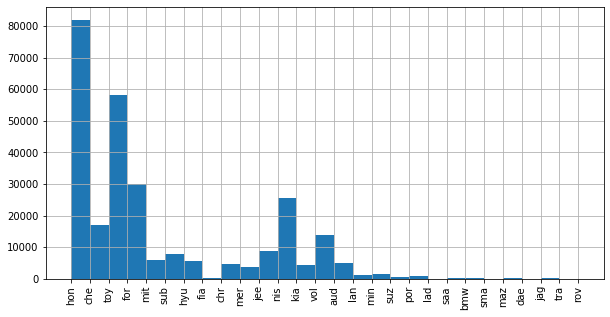

In [81]:
df_cured["brand_initials"].hist(bins=27, xrot=90, figsize=(10,5))

Most of the cars involved in infractions are Toyota, Honda and Ford. Is this the same distributions of the accidents?

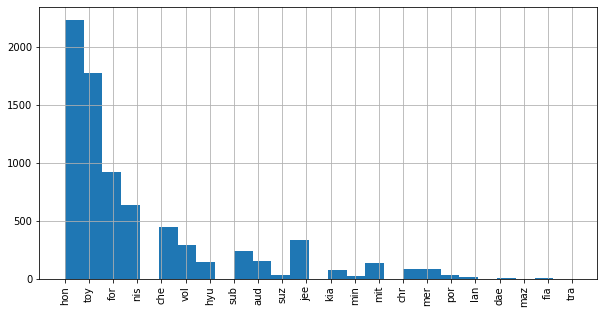

In [82]:
mask = df_cured["Contributed To Accident"]
df_cured[mask]["brand_initials"].hist(bins=27, xrot=90, figsize=(10,5))

Compared to the other plot, the brands still continued to be the same. It may be because of the amount of data of that attribute. Nevertheless, `nissan` reduces its participation in the accidents. It is difficult from the plots to see if there is a correlation between the vendor and the influence of accidents. The number of cars will, eventually, impact on the number of accidents produced by the vendor under analysis.

In [83]:
df_cured["time"] = pd.to_datetime(df_cured["Time Of Stop"], format='%H:%M:%S', errors='ignore')
df_cured["date"] = pd.to_datetime(df_cured["Date Of Stop"], format='%m:%d:%Y', errors='ignore')

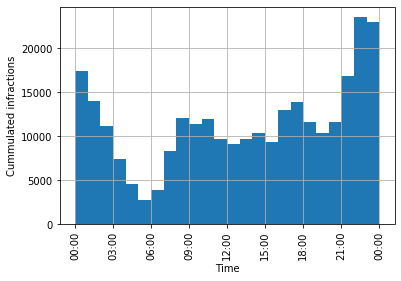

In [84]:
hist = df_cured["time"].hist(xrot=90, bins=24)
hist.set_xlabel("Time")
hist.set_ylabel("Cummulated infractions")
hist.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

During the early hours of the morning (2-7AM), the number of infractions are reduced.

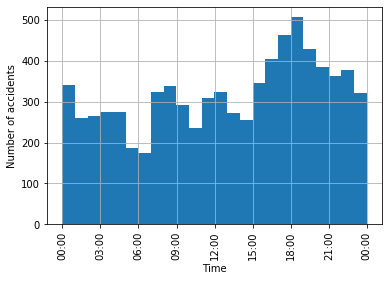

In [85]:
hist = df_cured[mask]["time"].hist(xrot=90, bins=24)
hist.set_xlabel("Time")
hist.set_ylabel("Number of accidents")
hist.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

The behaviour seems to be the same for the case of the accidents. The distributions tends to be the same. However, it is possible to see that the number of accidents are a way greater during the last part of the afternoon. A peak is reached at 18:00. This can be related to the commutation of the people to their places and the tireness caused by the jobs.

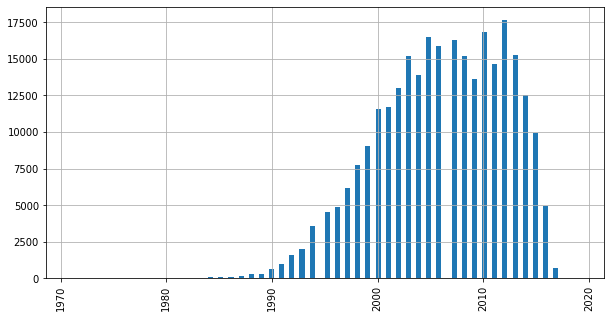

In [86]:
df_cured["Year"].hist(bins=100 ,xrot=90, figsize=(10,5))

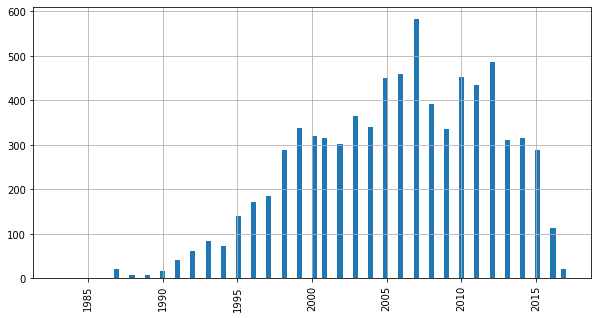

In [87]:
df_cured[mask]["Year"].hist(bins=100,xrot=90, figsize=(10,5))

Most of the cars involved in both, infractions and accidents are from the 2000 or later. It also matches with the most of cars sampled. From the plots presented above, it is not possible to determine a correlation between the year of the car with the accidents. However, it is possible to see the characteristics of the cars which are on the streets. For other purposes, these data may be really useful, such as insurance, controls, etc.

## Machine learning pipeline

The time for preparing the machine learning pipeline has come. The procedure is to change the categorical variables into numerical values with One-Hot-Encoding. About the numerical values, the year of the car comes as one of the numeric variables. Also, a new dataframe will be created as an input of the pipeline.

### Preprocessor

In [88]:
df_cured.columns

Index(['Date Of Stop', 'Time Of Stop', 'Agency', 'SubAgency', 'Description',
       'Location', 'Accident', 'Belts', 'Personal Injury', 'Property Damage',
       'Fatal', 'Commercial License', 'HAZMAT', 'Commercial Vehicle',
       'Alcohol', 'Work Zone', 'State', 'VehicleType', 'Year', 'Make', 'Model',
       'Violation Type', 'Charge', 'Contributed To Accident', 'Race', 'Gender',
       'Driver City', 'Driver State', 'DL State', 'Arrest Type',
       'Driver Origin', 'Vehicle', 'Full Location', 'model_initials',
       'brand_initials', 'License Issue', 'Speed Issue', 'Insurance Issue',
       'Wrong Manouver Issue', 'Car Lights Issue', 'Stop Sign Issue',
       'Reckless Issue', 'Safety Issue', 'Parking Issue', 'Drug Issue',
       'Register Issue', 'Distraction Issue', 'Obey Issue', 'Other Issue',
       'time', 'date'],
      dtype='object')

From all the columns presented above, the chosen ones are:

In [89]:
chosen = ["Year", "brand_initials", 'License Issue', 'Speed Issue', 'Insurance Issue',
       'Wrong Manouver Issue', 'Car Lights Issue', 'Stop Sign Issue',
       'Reckless Issue', 'Safety Issue', 'Parking Issue', 'Drug Issue',
       'Register Issue', 'Distraction Issue', 'Obey Issue', 'Other Issue',
       'time', 'Contributed To Accident'];

From those, one of them is the target: 'Contributed To Accident'

In [90]:
df_prep = df_cured[chosen].copy(deep=True)

For the numerical values, which are in potential: `year` and `time`, we are going to use the median for complete the missing data, if any. The date will be removed since it may not contribute to the analysis, since it is difficult to forecast accidents from the date. Also, the purpose of the analysis is to analyse the factors under the hood.

In [91]:
numeric_transformer = \
    Pipeline(
        steps=[('imputer', SimpleImputer(strategy='median')),
               ('scaler', StandardScaler())])

It is important to transform the `time` into an integer type

In [92]:
df_prep["time"] = pd.to_numeric(df_prep["time"])

For the categorical variables, we need to use the One-Hot-Encoder, which is the most used technique to deal with this kind of data. Also, the missing values are going to be set with a label: ""

In [93]:
categorical_transformer = \
    Pipeline(
        steps=[('imputer', SimpleImputer(strategy='constant', fill_value='')),
               ('onehot', OneHotEncoder(handle_unknown='ignore'))])

Now, it is time to feed the preprocessor data, choosing the variables for categoricals and numeric

In [94]:
numeric_features = ["Year", "time"]
categorical_features = ["brand_initials", 'License Issue', 'Speed Issue', \
                        'Insurance Issue', 'Wrong Manouver Issue', 'Car Lights Issue', 'Stop Sign Issue', \
                        'Reckless Issue', 'Safety Issue', 'Parking Issue', 'Drug Issue', 'Register Issue', \
                        'Distraction Issue', 'Obey Issue', 'Other Issue']

In [104]:
# Create an alias for the Target
target = 'Contributed To Accident'

To ease the process of building the preprocessor for each machine learning pipeline, this module will be encapsulated into a pipeline stage.

In [96]:
# Create the preprocessor
preprocessor = ColumnTransformer([('num', numeric_transformer, numeric_features),
                  ('cat', categorical_transformer, categorical_features)])

# Fit the preprocessor
preprocessor.fit_transform(df_prep)

<277405x58 sparse matrix of type '<class 'numpy.float64'>'
	with 4715885 stored elements in Compressed Sparse Row format>

Let's inspect the final matrix

In [97]:
# Reformat and print the sparse matrix to verify the data
category_names = []
for col in preprocessor.named_transformers_['cat']['onehot'].get_feature_names():
    idx = int(col.split('_')[0][1:])
    category_names.append(col.replace('x{0}'.format(idx), categorical_features[idx]))

new_cols = ['{0}_scaled'.format(x) for x in numeric_features] + category_names
df_inspect = pd.DataFrame.sparse.from_spmatrix(preprocessor.fit_transform(df_prep),
             columns = new_cols)
df_inspect.head(5)

Year_scaled  time_scaled  brand_initials_aud  brand_initials_bmw  \
0    -1.667685     0.356074                 0.0                 0.0   
1    -0.833947    -0.082495                 0.0                 0.0   
2    -0.333703     1.040509                 0.0                 0.0   
3    -0.166956     0.438029                 0.0                 0.0   
4    -2.167929    -0.013830                 0.0                 0.0   

   brand_initials_che  brand_initials_chr  brand_initials_dae  \
0                 0.0                 0.0                 0.0   
1                 0.0                 0.0                 0.0   
2                 1.0                 0.0                 0.0   
3                 0.0                 0.0                 0.0   
4                 0.0                 0.0                 0.0   

   brand_initials_fia  brand_initials_for  brand_initials_hon  ...  \
0                 0.0                 0.0                 1.0  ...   
1                 0.0                 0.0                 1.0  ...   
2                 0.0                 0.0                 0.0  ...   
3                 0.0                 0.0                 0.0  ...   
4                 0.0                 1.0                 0.0  ...   

   Drug Issue_False  Drug Issue_True  Register Issue_False  \
0               1.0              0.0                   1.0   
1               1.0              0.0                   1.0   
2               1.0              0.0                   1.0   
3               1.0              0.0                   1.0   
4               1.0              0.0                   0.0   

   Register Issue_True  Distraction Issue_False  Distraction Issue_True  \
0                  0.0                      0.0                     1.0   
1                  0.0                      1.0                     0.0   
2                  0.0                      1.0                     0.0   
3                  0.0                      1.0                     0.0   
4                  1.0                      1.0                     0.0   

   Obey Issue_False  Obey Issue_True  Other Issue_False  Other Issue_True  
0               1.0              0.0                1.0               0.0  
1               1.0              0.0                0.0               1.0  
2               1.0              0.0                1.0               0.0  
3               1.0              0.0                1.0               0.0  
4               1.0              0.0                1.0               0.0  

[5 rows x 58 columns]

Fromt the table above, it is possible to see that the time and the year of car has been normalised by using the Standard Deviation and scaled. Also, the One-Hot-Encoder has transformed every categorical variable in discrete numbers, being either 0 or 1 in most of the cases.

To use a Machine Learning technique, it is necessary to split the data into training and testing data.

In [98]:
train, test = train_test_split(df_prep, train_size = 0.7, random_state = 2)

In [99]:
print("Training-set:\n-target=0: {0}\n-target=1: {1}\n"\
          .format(train[train[target]==0].shape[0],
                  train[train[target]==1].shape[0]))

print("Training-set: percentage of target=1: {0}\n"\
     .format(train[train[target]==1].shape[0]/(train[train[target]==0].shape[0] \
                                                 +train[train[target]==1].shape[0])))

print("Test-set:\n-target=0: {0}\n-target=1: {1}\n"\
          .format(test[test[target]==0].shape[0],
                  test[test[target]==1].shape[0]))

print("Test-set: percentage of target 1: {0}\n"\
     .format(test[test[target]==1].shape[0]/(test[test[target]==0].shape[0]\
                                               +test[test[target]==1].shape[0])))

Training-set:
-target=0: 188810
-target=1: 5373

Training-set: percentage of target=1: 0.027669775418033504

Test-set:
-target=0: 80873
-target=1: 2349

Test-set: percentage of target 1: 0.02822570954795607



The distribution of the classes is highly unbalanced! This factor should be taken into account when using the hyperparameters in order to request balancing: `class_weight="balanced"`. This will contribute in the Decision Trees and other methods which are really sensible to the class weights.

The following cell will summarise the metrics wanted to compare each method according to their order of analysis and process of tuning.

In [107]:
def print_metrics(model):
    print('Accuracy:  ', accuracy_score(test[target],model.predict(test)))
    print('Precision: ', precision_score(test[target],model.predict(test)))
    print('Recall:    ', recall_score(test[target],model.predict(test)))
    print('F1:        ', f1_score(test[target],model.predict(test)))
    print('ROC-AUC:   ', roc_auc_score(test[target],model.predict(test)))
    print('\nConfusion Matrix\n{0}'.format(confusion_matrix(test[target],model.predict(test), normalize='true')))

### Logistic Regression Pipeline

In [101]:
#Logistic regression with cost sensitive learning
iter_num = 500
clf_lr = \
    Pipeline(steps=[('preprocessor', preprocessor),
                    ('classifier', LogisticRegression(solver='lbfgs', class_weight='balanced', max_iter=iter_num))])

clf_lr.fit(train,train[target])
print("Model Train Score: {0}".format(clf_lr.score(train,train[target])))
print("Model Test Score: {0}".format(clf_lr.score(test,test[target])))

Model Train Score: 0.6601813753006185
Model Test Score: 0.6619764004710293


In [275]:
%%time
clf_lr = \
    Pipeline(steps=[('preprocessor', preprocessor),
                    ('classifier', LogisticRegression(solver='newton-cg', class_weight='balanced'))])

clf_lr.fit(train,train[target])
print("Model Train Score: {0}".format(clf_lr.score(train,train[target])))
print("Model Test Score: {0}".format(clf_lr.score(test,test[target])))
print_metrics(clf_lr)

Model Train Score: 0.6601762255192267
Model Test Score: 0.6619764004710293
Accuracy:   0.6619764004710293
Precision:  0.05976367734444368
Recall:     0.744997871434653
F1:         0.11065094369447694
ROC-AUC:    0.7022814342026059

Confusion Matrix
[[0.659565   0.340435  ]
 [0.25500213 0.74499787]]
Wall time: 10.4 s


For both logistic regressions, but different solvers, the same score was achieved. It is important to recall that there is no overfitting in the model, which is a good sign. However, the score is really poor with logistic regression.  In the following cell, some metrics to evaluate these iterations are presented.

In [104]:
print_metrics(clf_lr)

Accuracy:   0.6619764004710293
Precision:  0.05976367734444368
Recall:     0.744997871434653
F1:         0.11065094369447694
ROC-AUC:    0.7022814342026059

Confusion Matrix
[[0.659565   0.340435  ]
 [0.25500213 0.74499787]]


These metrics suggest that the accuracy is not good, however, we have a good recall and the model is 75% OK while predicting falses. Also, it is possible to see that the balance between the True predictions are balanced, suggesting that we don't have an overfitting condition for this method.

### Decision Tree Pipeline

In [105]:
# Basic case
model = \
    DecisionTreeClassifier(criterion='gini', splitter='best',
                           max_depth=None, min_samples_split=2,
                           min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                           max_features=None, random_state=None, 
                           max_leaf_nodes=None, min_impurity_decrease=0.0, 
                           min_impurity_split=None, class_weight='balanced')

clf_dt = \
    Pipeline(steps=[('preprocessor', preprocessor),
                    ('classifier', model)])
clf_dt.fit(train,train[target])
print("Model Train Score: {0}".format(clf_dt.score(train,train[target])))
print("Model Test Score : {0}".format(clf_dt.score(test,test[target])))

Model Train Score: 0.9967659372859622
Model Test Score : 0.9593617072408738


With parameters at random, the decision tree was able to generalise the model with a high score. Nevertheless, the score seems really ideal. To inspect its state, let's have a look at the metrics.

In [106]:
print_metrics(clf_dt)

Accuracy:   0.9593617072408738
Precision:  0.3083487940630798
Recall:     0.3537675606641124
F1:         0.32950039651070584
ROC-AUC:    0.6653595386197418

Confusion Matrix
[[0.97695152 0.02304848]
 [0.64623244 0.35376756]]


The performance was quite good at first sight. However, looking at the precision and the recall, the model is not able to predict well one of the classes. Looking at the confusion matrix, the model is predicting really well the positives, but really bad at the negatives. The next step is to adjust the hyper parameters properly. For this job, GridSearch will be used:

In [114]:
param_grid = {
    'classifier__max_depth':range(3,10),
    'classifier__min_samples_split': [5,10,20],
    'classifier__min_samples_leaf': [2,3]}

n_folds = 10

gs = GridSearchCV(clf_dt, param_grid, 
                  scoring={'roc':'roc_auc','f1':'f1'},
                  n_jobs= -1, cv=n_folds, 
                  refit='roc', verbose=0, pre_dispatch='n_jobs', 
                  error_score='raise-deprecating', 
                  return_train_score=True)
n_fits = 1
for item in param_grid: 
    n_fits*=len(param_grid[item])
    
print('You are about to run {0} fits'.format(n_fits*n_folds))

You are about to run 420 fits


In [115]:
%%time
_ = gs.fit(train,train[target])
results = pd.DataFrame(data = gs.cv_results_)

Wall time: 5min 18s


For a complete graphical analysis, the following function will generate four plots which will compare the different hyperparameters within the manifold established before running the GridSearch. According to the data, the ideal case will be maximise all the plots with a single configuration of hyperparameters.

In [119]:
def tree_based_metrics():
    clrs = sns.color_palette("husl", max(len(param_grid['classifier__min_samples_split']),
                                     len(param_grid['classifier__max_depth'])))

    f = plt.figure(figsize=(20,12))
    ax = f.add_subplot(221)
    for idx,mss in enumerate(param_grid['classifier__min_samples_split']):
        x = results[results['param_classifier__min_samples_split']==mss]['param_classifier__max_depth']
        y = results[results['param_classifier__min_samples_split']==mss]['mean_test_roc']
        y_err = results[results['param_classifier__min_samples_split']==mss]['std_test_roc']
        ax.plot(x,y,'.-',label='min_samples_split = {0}'.format(mss),markersize=12, c=clrs[idx])
        ax.fill_between(x.astype(float),(y-y_err).astype(float),(y+y_err).astype(float),facecolor=clrs[idx], alpha=0.1)
    ax.set_ylabel('mean_test_roc')
    ax.set_xlabel('max_depth')
    ax.grid(which='both')
    ax.legend()

    ax = f.add_subplot(222)
    for idx,md in enumerate(param_grid['classifier__max_depth']):
        x = results[results['param_classifier__max_depth']==md]['param_classifier__min_samples_split']
        y = results[results['param_classifier__max_depth']==md]['mean_test_roc']
        y_err = results[results['param_classifier__max_depth']==md]['std_test_roc']
        ax.plot(x,y,'.-',label='max_depth = {0}'.format(md),markersize=12, c=clrs[idx])
        ax.fill_between(x.astype(float),(y-y_err).astype(float),(y+y_err).astype(float),facecolor=clrs[idx], alpha=0.1)
    ax.set_ylabel('mean_test_roc')
    ax.set_xlabel('min_samples_split')
    ax.grid(which='both')
    ax.legend()


    ax = f.add_subplot(223)
    for idx,mss in enumerate(param_grid['classifier__min_samples_split']):
        x = results[results['param_classifier__min_samples_split']==mss]['param_classifier__max_depth']
        n = results[results['param_classifier__min_samples_split']==mss]['mean_test_roc']
        s_n = results[results['param_classifier__min_samples_split']==mss]['std_test_roc']
        d = results[results['param_classifier__min_samples_split']==mss]['mean_train_roc']
        s_d = results[results['param_classifier__min_samples_split']==mss]['std_train_roc']
        y = n / d
        y_err = np.sqrt((s_n/d)*(s_n/d)+(n*s_d/(d*d))*(n*s_d/(d*d))) 
        ax.plot(x,y,'.-',label='min_samples_split = {0}'.format(mss),markersize=12,c=clrs[idx])
        ax.fill_between(x.astype(float),(y-y_err).astype(float),(y+y_err).astype(float),facecolor=clrs[idx], alpha=0.1)

    ax.set_ylabel('training/test (mean_test_roc)')
    ax.set_xlabel('max_depth')
    ax.grid(which='both')
    ax.legend()

    ax = f.add_subplot(224)
    for idx,md in enumerate(param_grid['classifier__max_depth']):
        x = results[results['param_classifier__max_depth']==md]['param_classifier__min_samples_split']
        y = results[results['param_classifier__max_depth']==md]['mean_test_roc'] / \
            results[results['param_classifier__max_depth']==md]['mean_train_roc']

        n = results[results['param_classifier__max_depth']==md]['mean_test_roc']
        s_n = results[results['param_classifier__max_depth']==md]['std_test_roc']
        d = results[results['param_classifier__max_depth']==md]['mean_train_roc']
        s_d = results[results['param_classifier__max_depth']==md]['std_train_roc']
        y = n / d
        y_err = np.sqrt((s_n/d)*(s_n/d)+(n*s_d/(d*d))*(n*s_d/(d*d))) 
        ax.plot(x,y,'.-',label='max_depth = {0}'.format(md),markersize=12,c=clrs[idx])
        ax.fill_between(x.astype(float),(y-y_err).astype(float),(y+y_err).astype(float),facecolor=clrs[idx], alpha=0.1)
    ax.set_ylabel('training/test (mean_test_roc)')
    ax.set_xlabel('min_samples_split')
    ax.grid(which='both')
    ax.legend()

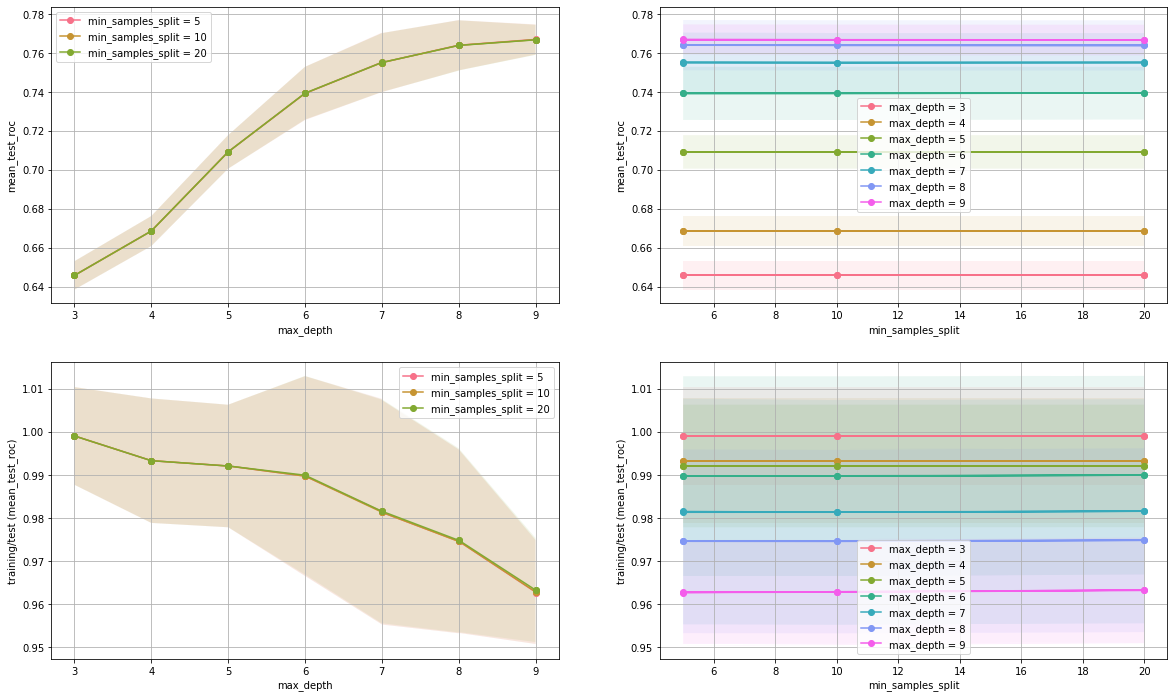

In [120]:
tree_based_metrics()

According to the plots, the best choice for training is:

* `max_depth = 9`: produce a bit of overfitting (96.5% of balance)
* `min_samples_split = 5`: maximises the roc

An important point to analyse from the plots is that, the `max_depth`, the greater its value, the better is the `test roc`, but lower is the reason of the rocs. Receiver operating characteristic (ROC) is a matric for binary classificator, and it determine the reason of True Positives agains the False Positives. The higher, the better.

In [121]:
results.sort_values(by=['mean_test_roc'], ascending =False).head(5)[['mean_train_roc', \
                                                                     'mean_test_roc', \
                                                                     'param_classifier__max_depth', \
                                                                     'param_classifier__min_samples_leaf', \
                                                                     'param_classifier__min_samples_split'
                                                                    ]]

mean_train_roc  mean_test_roc param_classifier__max_depth  \
36        0.796627       0.766959                           9   
37        0.796428       0.766810                           9   
39        0.796478       0.766742                           9   
38        0.796003       0.766741                           9   
40        0.796361       0.766694                           9   

   param_classifier__min_samples_leaf param_classifier__min_samples_split  
36                                  2                                   5  
37                                  2                                  10  
39                                  3                                   5  
38                                  2                                  20  
40                                  3                                  10

From the table above, we can analyse the balance between ROCs on the training and testing sets. The best choice for `min_samples_leaf` is `2`, which maximises the `mean_test_roc` and keeps the balance at the same time.

With this configuration, the Decision Tree is going to be retrained below:

In [270]:
%%time
model = \
    DecisionTreeClassifier(criterion='gini', splitter='best',
                           max_depth=9, min_samples_split=5,
                           min_samples_leaf=2, min_weight_fraction_leaf=0.0, 
                           max_features=None, random_state=None, 
                           max_leaf_nodes=None, min_impurity_decrease=0.0, 
                           min_impurity_split=None, class_weight='balanced')

clf_dt = \
    Pipeline(steps=[('preprocessor', preprocessor),
                    ('classifier', model)])
clf_dt.fit(train,train[target])
print("Model Train Score: {0}".format(clf_dt.score(train,train[target])))
print("Model Test Score : {0}".format(clf_dt.score(test,test[target])))
print_metrics(clf_dt)

Model Train Score: 0.7073739719748897
Model Test Score : 0.7086347360073058
Accuracy:   0.7086347360073058
Precision:  0.06623618428871371
Recall:     0.711792252022137
F1:         0.12119454914467963
ROC-AUC:    0.7101676381350159

Confusion Matrix
[[0.70854302 0.29145698]
 [0.28820775 0.71179225]]
Wall time: 6.17 s


Compared to before, the confusion matrix is more balanced in terms of truth predictions, but the accuracy is still low (~71%). It seems to be the roof of accuracy of this method for the hyperparameters manifold and the data provided.

### Random Forest Pipeline

The random forest method is not too different from the Decision Tree process. There is a new hyperparameter, which is the `n_estimators`, that determines the number of decision trees in the forest. 

Below, a base configuration without any tuning is tried:

In [123]:
model = \
    RandomForestClassifier( n_estimators=100, criterion='gini', 
                            max_depth=None, min_samples_split=2, 
                            min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                            max_features='auto', max_leaf_nodes=None, 
                            min_impurity_decrease=0.0, min_impurity_split=None, 
                            bootstrap=True, oob_score=False, 
                            n_jobs=-1, random_state=None, verbose=0, 
                            warm_start=False,  
                            ccp_alpha=0.0, max_samples=None, class_weight='balanced')

clf_rf = \
    Pipeline(steps=[('preprocessor', preprocessor),
                    ('classifier', model)])
clf_rf.fit(train,train[target])
print("Model Train Score: {0}".format(clf_rf.score(train,train[target])))
print("Model Test Score : {0}".format(clf_rf.score(test,test[target])))

Model Train Score: 0.9967350385976115
Model Test Score : 0.9701641392900916


In [124]:
print_metrics(clf_rf)

Accuracy:   0.9701641392900916
Precision:  0.45802005012531327
Recall:     0.3111962537249894
F1:         0.3705956907477821
ROC-AUC:    0.6502502357245377

Confusion Matrix
[[0.98930422 0.01069578]
 [0.68880375 0.31119625]]


Since the hyperparameters for the Decision Trees are the same as the Decision Tree model tested before, the recall is really slow, suggesting an unbalance. Also, it can be noticed from the confusion matrix coefficients, which indicates that the model is really good at predicting True Positives, but really bad with True Negatives.

The hyperparameters tuning is quite similar to the performed above. The `n_estimators` within the manifold is only tested with `100` and `200`. `50` has been tested also, and `100` hundred was still better.

In [264]:
param_grid = {
    'classifier__max_depth':range(3,12, 2),
    'classifier__min_samples_split': [10,20,40],
    'classifier__n_estimators': [100,200, 250],
    'classifier__min_samples_leaf': [2,3]}

n_folds = 5

gs = GridSearchCV(clf_rf, param_grid, 
                  scoring={'roc':'roc_auc','f1':'f1'},
                  n_jobs= -1, cv=n_folds, 
                  refit='roc', verbose=0, pre_dispatch='n_jobs', 
                  error_score='raise-deprecating', 
                  return_train_score=True)
n_fits = 1
for item in param_grid: 
    n_fits*=len(param_grid[item])
    
print('You are about to run {0} fits'.format(n_fits*n_folds))

You are about to run 450 fits


In [265]:
%%time
_ = gs.fit(train,train[target])
results = pd.DataFrame(data = gs.cv_results_)

Wall time: 50min 38s


In [266]:
results.sort_values(by=['mean_test_roc'], ascending =False).head(5)[['mean_train_roc', \
                                                                     'mean_test_roc', \
                                                                     'param_classifier__max_depth', \
                                                                     'param_classifier__min_samples_leaf', \
                                                                     'param_classifier__min_samples_split', \
                                                                     'param_classifier__n_estimators'
                                                                    ]]

mean_train_roc  mean_test_roc param_classifier__max_depth  \
76        0.813431       0.790582                          11   
77        0.813516       0.790238                          11   
74        0.814303       0.790211                          11   
73        0.814513       0.789978                          11   
81        0.813727       0.789899                          11   

   param_classifier__min_samples_leaf param_classifier__min_samples_split  \
76                                  2                                  20   
77                                  2                                  20   
74                                  2                                  10   
73                                  2                                  10   
81                                  3                                  10   

   param_classifier__n_estimators  
76                            200  
77                            250  
74                            250  
73                            200  
81                            100

The optimal parameters in this case are:

* `max_depth` = 11
* `min_samples_split` = 20
* `min_samples_leaf` = 2
* `n_estimators` = 200

About the number of estimators, its optimal number is 200 within the analysed manifold.

The model with the optimal tuning is presented below:

In [271]:
%%time
model = \
    RandomForestClassifier( n_estimators=200, criterion='gini', 
                            max_depth=11, min_samples_split=20, 
                            min_samples_leaf=2, min_weight_fraction_leaf=0.0, 
                            max_features='auto', max_leaf_nodes=None, 
                            min_impurity_decrease=0.0, min_impurity_split=None, 
                            bootstrap=True, oob_score=False, 
                            n_jobs=-1, random_state=None, verbose=0, 
                            warm_start=False,  
                            ccp_alpha=0.0, max_samples=None, class_weight='balanced')

clf_rf = \
    Pipeline(steps=[('preprocessor', preprocessor),
                    ('classifier', model)])
clf_rf.fit(train,train[target])
print("Model Train Score: {0}".format(clf_rf.score(train,train[target])))
print("Model Test Score : {0}".format(clf_rf.score(test,test[target])))

print_metrics(clf_rf)

Model Train Score: 0.6670769325842117
Model Test Score : 0.6683689409050492
Accuracy:   0.6683689409050492
Precision:  0.06302782777239374
Recall:     0.7752234993614304
F1:         0.11657757434141033
ROC-AUC:    0.7202443959285358

Confusion Matrix
[[0.66526529 0.33473471]
 [0.2247765  0.7752235 ]]
Wall time: 21.9 s


The accuracy achieved by the random forest is still low and it may need more tuning.

Also, in terms of speed, The Random Forest is slower than a single Decision Tree.

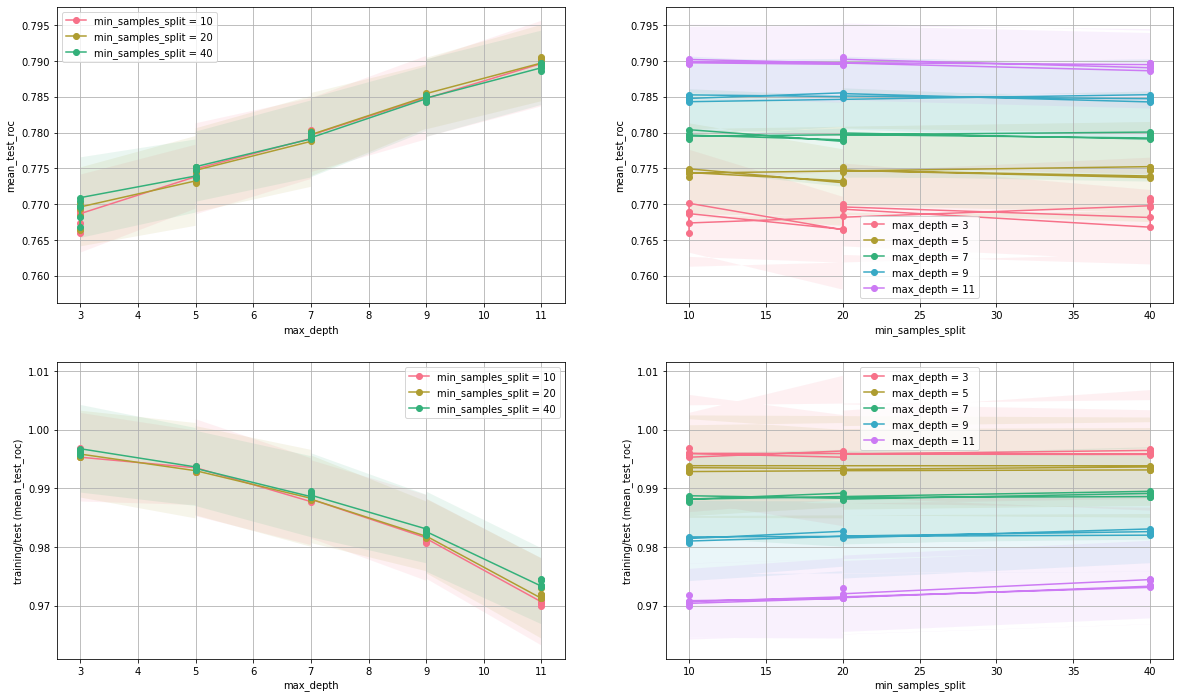

In [269]:
tree_based_metrics()

From the plots, it is possible to notice that, increasing the `max_depth` will lead to a better test roc, but the overfitting will increase, especially looking at the plot of training/test roc against the max_depth.

### Bernoulli Naive Bayes

From the family of Naïve Bayes classifiers, the Bernoulli is the best choice for Binary Classification. A simple pipeline is presented below:

In [185]:
# Basic case
model = \
    BernoulliNB()

clf_bnb = \
    Pipeline(steps=[('preprocessor', preprocessor),
                    ('classifier', model)])
clf_bnb.fit(train,train[target])
print("Model Train Score: {0}".format(clf_bnb.score(train,train[target])))
print("Model Test Score : {0}".format(clf_bnb.score(test,test[target])))

Model Train Score: 0.9722890263308323
Model Test Score : 0.9716541299175698


In [151]:
print_metrics(clf_bnb)

Accuracy:   0.9716541299175698
Precision:  0.08333333333333333
Recall:     0.0004257130693912303
F1:         0.0008470986869970351
ROC-AUC:    0.5001448486705135

Confusion Matrix
[[9.99863984e-01 1.36015728e-04]
 [9.99574287e-01 4.25713069e-04]]


According to the metrics, especially the Confusion Matrix, the model is not able to generalise the dataset. It is biased by one of the classes, leading to Negative misprediction.

In [156]:
param_grid = {
    'classifier__alpha':np.linspace(0.1, 1, 20)}

n_folds = 10

gs = GridSearchCV(clf_bnb, param_grid, 
                  scoring={'roc':'roc_auc','f1':'f1'},
                  n_jobs= -1, cv=n_folds, 
                  refit='roc', verbose=0, pre_dispatch='n_jobs', 
                  error_score='raise-deprecating', 
                  return_train_score=True)
n_fits = 1
for item in param_grid: 
    n_fits*=len(param_grid[item])
    
print('You are about to run {0} fits'.format(n_fits*n_folds))

You are about to run 200 fits


In [157]:
%%time
_ = gs.fit(train,train[target])
results = pd.DataFrame(data = gs.cv_results_)

Wall time: 2min 15s


In [158]:
results.sort_values(by=['mean_test_roc'], ascending =False).head(5)[['mean_train_roc', \
                                                                     'mean_test_roc', \
                                                                     'param_classifier__alpha'
                                                                    ]]

mean_train_roc  mean_test_roc param_classifier__alpha
4         0.760733       0.759808                0.289474
5         0.760725       0.759804                0.336842
9         0.760695       0.759803                0.526316
0         0.760802       0.759800                     0.1
10        0.760686       0.759800                0.573684

In [273]:
%%time
model = \
    BernoulliNB(alpha=0.289474)

clf_bnb = \
    Pipeline(steps=[('preprocessor', preprocessor),
                    ('classifier', model)])
clf_bnb.fit(train,train[target])
print("Model Train Score: {0}".format(clf_bnb.score(train,train[target])))
print("Model Test Score : {0}".format(clf_bnb.score(test,test[target])))
print_metrics(clf_bnb)

Model Train Score: 0.972294176112224
Model Test Score : 0.9716541299175698
Accuracy:   0.9716541299175698
Precision:  0.08333333333333333
Recall:     0.0004257130693912303
F1:         0.0008470986869970351
ROC-AUC:    0.5001448486705135

Confusion Matrix
[[9.99863984e-01 1.36015728e-04]
 [9.99574287e-01 4.25713069e-04]]
Wall time: 4.78 s


With BNB, the training takes less time compared to the other methods applied so far. However, the final results are not as good as expected.

### SVM

For the data, which may be not linear, the best choice is to use the Non-linear configuration by introducing a kernel. Both, the polynomial and the `rbf` kernels are tested below.

In [169]:
# Basic case
model = \
    SVC(kernel="poly", gamma="auto")

clf_svm = \
    Pipeline(steps=[('preprocessor', preprocessor),
                    ('classifier', model)])
clf_svm.fit(train,train[target])
print("Model Train Score: {0}".format(clf_svm.score(train,train[target])))
print("Model Test Score : {0}".format(clf_svm.score(test,test[target])))
print_metrics(clf_svm)

Model Train Score: 0.9723302245819665
Model Test Score : 0.9717742904520439
Accuracy:   0.9717742904520439


C:\Users\lleon95\anaconda3\envs\py3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision:  0.0
Recall:     0.0
F1:         0.0
ROC-AUC:    0.5

Confusion Matrix
[[1. 0.]
 [1. 0.]]


In [171]:
# Basic case
model = \
    SVC(kernel="rbf", gamma="auto")

clf_svm = \
    Pipeline(steps=[('preprocessor', preprocessor),
                    ('classifier', model)])
clf_svm.fit(train,train[target])
print("Model Train Score: {0}".format(clf_svm.score(train,train[target])))
print("Model Test Score : {0}".format(clf_svm.score(test,test[target])))
print_metrics(clf_svm)

Model Train Score: 0.9723302245819665
Model Test Score : 0.9717742904520439
Accuracy:   0.9717742904520439


C:\Users\lleon95\anaconda3\envs\py3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision:  0.0
Recall:     0.0
F1:         0.0
ROC-AUC:    0.5

Confusion Matrix
[[1. 0.]
 [1. 0.]]


The SVM is not able to work properly with the dataset, even with other configurations. The warning appeared as a result of having zeros in the True Negative and the False Positive, observed by using the Confusion Matrix.

### AdaBoost

The AdaBoost is one of the several so-called *ensemble* methods, which their principle is to combine several weak classifiers to make a stronger classifier. For the case presented below, the "weak classifier is a Decision Tree", with the settings chosen as the best for the Decision Tree section. The hyperparameters of AdaBoost are in this case:

* Number of estimators: which corresponds to the number of decision trees.
* Learning rate: which assigns the weights of each estimator on the final result.

In [225]:
from sklearn.ensemble import AdaBoostClassifier

Denser = FunctionTransformer(lambda x: x.todense(), accept_sparse=True)

dt_classifier = DecisionTreeClassifier(criterion='gini', splitter='best',
                           max_depth=9, min_samples_split=5,
                           min_samples_leaf=2, min_weight_fraction_leaf=0.0, 
                           max_features=None, random_state=None, 
                           max_leaf_nodes=None, min_impurity_decrease=0.0, 
                           min_impurity_split=None, class_weight='balanced')

model = AdaBoostClassifier(base_estimator=dt_classifier, n_estimators=20, learning_rate=1.5, random_state=0)

clf_ab = \
    Pipeline(steps=[('preprocessor', preprocessor),
                    ('denser', Denser),
                    ('classifier', model)])
clf_ab.fit(train,train[target])
print("Model Train Score: {0}".format(clf_ab.score(train,train[target])))
print("Model Test Score : {0}".format(clf_ab.score(test,test[target])))
print_metrics(clf_ab)

Model Train Score: 0.8452490691770135
Model Test Score : 0.8322078296604263
Accuracy:   0.8322078296604263
Precision:  0.10560271646859083
Recall:     0.6619838229033631
F1:         0.18214829565421106
ROC-AUC:    0.7495679504263701

Confusion Matrix
[[0.83715208 0.16284792]
 [0.33801618 0.66198382]]


The first run by choosing the hyperparameters randomly, the accuracy seems really good for the True Positives, but is unbalanced when considering the other class. For tuning it, a for loop will be used for testing the several configurations.

In [276]:
benchmarking_ab = {"roc":[], "acc":[], "cond":[]}
config_n = 1
for lr in [0.7,0.9,1.2,1.8,3]:
    for ne in [5,10,20,50]:
        model = AdaBoostClassifier(base_estimator=dt_classifier, n_estimators=ne, \
                                   learning_rate=lr, random_state=0)

        clf_ab = \
                Pipeline(steps=[('preprocessor', preprocessor),
                                ('denser', Denser),
                                ('classifier', model)])
        clf_ab.fit(train,train[target])
        benchmarking_ab["cond"].append((lr, ne))
        benchmarking_ab["acc"].append(accuracy_score(test[target],clf_ab.predict(test)))
        benchmarking_ab["roc"].append(roc_auc_score(test[target],clf_ab.predict(test)))
        print("Idx: ", config_n,"For lr:", lr, "ne", ne)
        config_n += 1

Idx:  1 For lr: 0.7 ne 5
Idx:  2 For lr: 0.7 ne 10
Idx:  3 For lr: 0.7 ne 20
Idx:  4 For lr: 0.7 ne 50
Idx:  5 For lr: 0.9 ne 5
Idx:  6 For lr: 0.9 ne 10
Idx:  7 For lr: 0.9 ne 20
Idx:  8 For lr: 0.9 ne 50
Idx:  9 For lr: 1.2 ne 5
Idx:  10 For lr: 1.2 ne 10
Idx:  11 For lr: 1.2 ne 20
Idx:  12 For lr: 1.2 ne 50
Idx:  13 For lr: 1.8 ne 5
Idx:  14 For lr: 1.8 ne 10
Idx:  15 For lr: 1.8 ne 20
Idx:  16 For lr: 1.8 ne 50
Idx:  17 For lr: 3 ne 5
Idx:  18 For lr: 3 ne 10
Idx:  19 For lr: 3 ne 20
Idx:  20 For lr: 3 ne 50


Text(0.5, 0, 'Configuration Number')

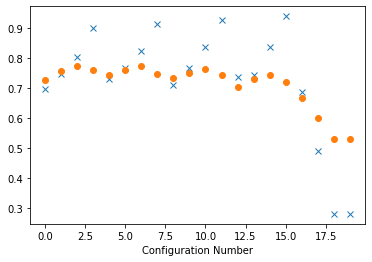

In [277]:
plt.plot(benchmarking_ab["acc"], 'x', label="ACC")
plt.plot(benchmarking_ab["roc"], 'o', label="ROC")
plt.xlabel("Configuration Number")

From the plot, it is possible to notice that the 3rd configuration performs better than the others with the following hyperparameters:

* `n_estimators`: 20
* `learning_rate`: 0.7

In [278]:
%%time
model = AdaBoostClassifier(base_estimator=dt_classifier, n_estimators=20, learning_rate=0.7, random_state=0)

clf_ab = \
    Pipeline(steps=[('preprocessor', preprocessor),
                    ('denser', Denser),
                    ('classifier', model)])
clf_ab.fit(train,train[target])
print("Model Train Score: {0}".format(clf_ab.score(train,train[target])))
print("Model Test Score : {0}".format(clf_ab.score(test,test[target])))
print_metrics(clf_ab)

Model Train Score: 0.8135624642733916
Model Test Score : 0.8025281776453341
Accuracy:   0.8025281776453341
Precision:  0.09892362890825218
Recall:     0.7394636015325671
F1:         0.174502712477396
ROC-AUC:    0.7719117619399756

Confusion Matrix
[[0.80435992 0.19564008]
 [0.2605364  0.7394636 ]]
Wall time: 36.6 s


The results, in terms of accuracy, are bettern than the other methods inspected before. This comes with the fact that AdaBoost strenght is based on composition of several classifiers instead of being just one complete classifier.

### Hist_gradient_boosting 

The HGB is another ensemble method based on the Gradients Histogram. This takes as a base the boosting sampling method to adjust the model to the data. In the case of SkLearn, it is an experimental method.

In [251]:
%%time

model = HistGradientBoostingClassifier()

clf_hgb = \
    Pipeline(steps=[('preprocessor', preprocessor),
                    ('denser', Denser),
                    ('classifier', model)])

clf_hgb.fit(train,train[target])
print("Model Train Score: {0}".format(clf_hgb.score(train,train[target])))
print("Model Test Score : {0}".format(clf_hgb.score(test,test[target])))
print_metrics(clf_hgb)

Model Train Score: 0.9728761014094952
Model Test Score : 0.9720266275744395
Accuracy:   0.9720266275744395
Precision:  0.7441860465116279
Recall:     0.01362281822051937
F1:         0.026755852842809368
ROC-AUC:    0.5067434012460776

Confusion Matrix
[[9.99863984e-01 1.36015728e-04]
 [9.86377182e-01 1.36228182e-02]]


To find the best hyperparameter configuration from a manifold, the following loop will train the model for several hyperparameter combinations.

In [254]:
benchmarking_hgb = {"roc":[], "acc":[], "cond":[]}
for lr in [0.7,0.9,1.2,1.8,3]:
    for mi in [100,200]:
        for mln in [20, 40, 100]:
            model = HistGradientBoostingClassifier(learning_rate=lr, max_iter=mi, max_leaf_nodes=mln)

            clf_hgb = \
                Pipeline(steps=[('preprocessor', preprocessor),
                                ('denser', Denser),
                                ('classifier', model)])

            clf_hgb.fit(train,train[target])
            benchmarking_hgb["cond"].append((lr, mi, mln))
            benchmarking_hgb["acc"].append(accuracy_score(test[target],clf_hgb.predict(test)))
            benchmarking_hgb["roc"].append(roc_auc_score(test[target],clf_hgb.predict(test)))
            print("For lr:", lr, "mi", mi, "mln", mln)

For lr: 0.7 mi 100 mln 20
For lr: 0.7 mi 100 mln 40
For lr: 0.7 mi 100 mln 100
For lr: 0.7 mi 200 mln 20
For lr: 0.7 mi 200 mln 40
For lr: 0.7 mi 200 mln 100
For lr: 0.9 mi 100 mln 20
For lr: 0.9 mi 100 mln 40
For lr: 0.9 mi 100 mln 100
For lr: 0.9 mi 200 mln 20
For lr: 0.9 mi 200 mln 40
For lr: 0.9 mi 200 mln 100
For lr: 1.2 mi 100 mln 20
For lr: 1.2 mi 100 mln 40
For lr: 1.2 mi 100 mln 100
For lr: 1.2 mi 200 mln 20
For lr: 1.2 mi 200 mln 40
For lr: 1.2 mi 200 mln 100
For lr: 1.8 mi 100 mln 20
For lr: 1.8 mi 100 mln 40
For lr: 1.8 mi 100 mln 100
For lr: 1.8 mi 200 mln 20
For lr: 1.8 mi 200 mln 40
For lr: 1.8 mi 200 mln 100
For lr: 3 mi 100 mln 20
For lr: 3 mi 100 mln 40
For lr: 3 mi 100 mln 100
For lr: 3 mi 200 mln 20
For lr: 3 mi 200 mln 40
For lr: 3 mi 200 mln 100


Text(0.5, 0, 'Configuration Number')

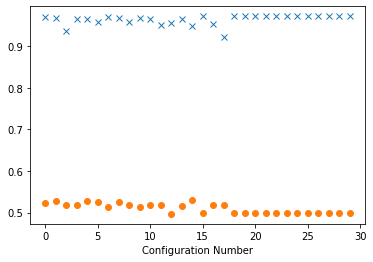

In [279]:
plt.plot(benchmarking_hgb["acc"], 'x', label="ACC")
plt.plot(benchmarking_hgb["roc"], 'o', label="ROC")
plt.xlabel("Configuration Number")

From the plot, it is possible no notice that this method doesn't perform very well on the dataset, since the ROC keeps almost flat, suggesting an unbalance between the predictions. The accuracy seems to be high, but it is just an impression. The "best" hyperparameter is given by:

In [256]:
benchmarking_hgb["cond"][14]

(1.2, 100, 100)

Trying to fit those hyperparameters, the results are:

In [280]:
%%time

model = HistGradientBoostingClassifier(learning_rate=1.2, max_iter=100, max_leaf_nodes=100)

clf_hgb = \
    Pipeline(steps=[('preprocessor', preprocessor),
                    ('denser', Denser),
                    ('classifier', model)])

clf_hgb.fit(train,train[target])
print("Model Train Score: {0}".format(clf_hgb.score(train,train[target])))
print("Model Test Score : {0}".format(clf_hgb.score(test,test[target])))
print_metrics(clf_hgb)

Model Train Score: 0.9500728694066937
Model Test Score : 0.9484511307106294
Accuracy:   0.9484511307106294
Precision:  0.08719693747341557
Recall:     0.08727117922520221
F1:         0.08723404255319149
ROC-AUC:    0.5303678735639816

Confusion Matrix
[[0.97346457 0.02653543]
 [0.91272882 0.08727118]]
Wall time: 18 s


## Results

According to all the results collected during the analysis of each method, the following table helps to summarise the main results.

| Classification Method | Score (Test) | Score (Train) | ROC-AUC   |  Recall    |  Precision | Train Time |
|-----------------------|--------------|---------------|-----------|------------|------------|------------|
| Logistic Regression   | 0.661976     | 0.660176      | 0.70228   | 0.744998   | 0.05976    | 10.4 s     |
| Decision Tree         | 0.708635     | 0.707374      | 0.71017   | 0.711792   | 0.06624    | 6.17 s     |
| Random Forest         | 0.667077     | 0.667077      | 0.72024   | 0.711792   | 0.06303    | 21.9 s     |
| Bernoulli Naïve Bayes | 0.971654     | 0.972294      | 0.50014   | 0.711792   | 0.08333    | 4.78 s     |
| SVM                   | 0.971774     | 0.972330      | 0.00000   | 0.000000   | 0.00000    | ------     |
| AdaBoost              | 0.802528     | 0.813562      | 0.77191   | 0.739463   | 0.09892    | 36.6 s     |
| Histogram Gradient B. | 0.948451     | 0.950072      | 0.53037   | 0.087271   | 0.08720    | 18.0 s     |

The table shown above summarises the benchmark results after the hyperparameter tuning on each method. It is possible to see that several methods are not suitable and give wrong results for this data set. Their results tend to bias to the asserted value of the class (True), suggesting that there are kind of bias on the data. The best result is given by Adaboost, which is more resilient to the dataset and the possible biases within the data.

The AdaBoost gives the highest ROC and less overfitted results. However, the training time takes more time compared to the other methods. Therefore, the accuracy is about 80%, which is not bad, but it could be even better with another method or with more data curation.

### Variable importance

There should be some reason for the methods which failed when generalising the model. To do some examination about this, it is quite good to have a look at the variable relevance.

**Adaboost - Reference**

In [286]:
coeffs_ab = {}
counter = 0
for idx, item in enumerate(clf_ab['classifier'].feature_importances_):
    coeffs_ab[new_cols[idx]] = item
for key in sorted(coeffs_ab,key=lambda x: abs(coeffs_ab[x]),reverse=True):
    if coeffs_ab[key]!=0 and counter < 6:
        print("{0:40}:{1}".format(key,coeffs_ab[key]))
    counter += 1

time_scaled                             :0.44160986806426045
Year_scaled                             :0.23369626979818842
brand_initials_suz                      :0.027553023786907667
brand_initials_hon                      :0.025013149725756235
brand_initials_for                      :0.02442176099980385
Drug Issue_True                         :0.01887607550104417


In the case of the Adaboost, the time plays a important role on the accidents, followed by the year of the car, some brands and the drugs issue.

Wisely, the brand played an important role for the classification in the adaboost case.

**Decision Tree**

In [287]:
coeffs_dt = {}
counter = 0
for idx, item in enumerate(clf_dt['classifier'].feature_importances_):
    coeffs_dt[new_cols[idx]] = item
for key in sorted(coeffs_dt,key=lambda x: abs(coeffs_dt[x]),reverse=True):
    if coeffs_dt[key]!=0 and counter < 6:
        print("{0:40}:{1}".format(key,coeffs_dt[key]))
    counter += 1

Drug Issue_True                         :0.22742551020888138
time_scaled                             :0.1496245762317001
Wrong Manouver Issue_True               :0.12814824377761974
Drug Issue_False                        :0.10638359586681408
Stop Sign Issue_True                    :0.08422602367826416
Speed Issue_False                       :0.0769492789092399


From the variables presented for the decision tree. The drug consumption and the time continued to be relevant. Albeit, there is a huge problem which haven't been detected before. There are some correlated variables after the preprocessing. This is shown by the Drug Issue:

Drug Issue_True
Drug Issue_False

Both variables are strongly correlated. This might lead to poor results on methods which don't tolerate correlation.

Unfortunately, for those methods which failed, it is not possible to get the feature importance property.

### Encoding issue

The problem with the variables is a way deeper, the best strategy is to convert them into numerics instead of treating them as categoricals. Let's have a look and see the results.

In [93]:
numeric_features = ["Year", "time", 'License Issue', 'Speed Issue', \
                    'Insurance Issue', 'Wrong Manouver Issue', 'Car Lights Issue', 'Stop Sign Issue', \
                    'Reckless Issue', 'Safety Issue', 'Parking Issue', 'Drug Issue', 'Register Issue', \
                    'Distraction Issue', 'Obey Issue']
categorical_features = ["brand_initials"]

Replace boolean by numeric

In [97]:
# Transform the categoricals into numeric values by replacing the values
to_convert = ['License Issue', 'Speed Issue', \
            'Insurance Issue', 'Wrong Manouver Issue', 'Car Lights Issue', 'Stop Sign Issue', \
            'Reckless Issue', 'Safety Issue', 'Parking Issue', 'Drug Issue', 'Register Issue', \
            'Distraction Issue', 'Obey Issue']
for elem in to_convert:
    df_prep[elem] = df_prep[elem].astype(int)

Reconstruct the pipeline:

In [99]:
categorical_transformer = \
    Pipeline(
        steps=[('imputer', SimpleImputer(strategy='constant', fill_value='')),
               ('onehot', OneHotEncoder(handle_unknown='ignore'))])

numeric_transformer = \
    Pipeline(
        steps=[('imputer', SimpleImputer(strategy='median')),
               ('scaler', StandardScaler())])

preprocessor = ColumnTransformer([('num', numeric_transformer, numeric_features),
                  ('cat', categorical_transformer, categorical_features)])

# Fit the preprocessor
preprocessor.fit_transform(df_prep).shape

(277405, 43)

The number of attributes were reduced from 58 to 43.

Below, some operations needed for the following cells

In [117]:
# Reformat and print the sparse matrix to verify the data
category_names = []
for col in preprocessor.named_transformers_['cat']['onehot'].get_feature_names():
    idx = int(col.split('_')[0][1:])
    category_names.append(col.replace('x{0}'.format(idx), categorical_features[idx]))

new_cols = ['{0}_scaled'.format(x) for x in numeric_features] + category_names

In [102]:
train, test = train_test_split(df_prep, train_size = 0.7, random_state = 2)
target = 'Contribute to Accident'

The following decision tree was rerun with the optimal values got below. Please, take it into account.

In [116]:
%%time
model = \
    DecisionTreeClassifier(criterion='gini', splitter='best',
                           max_depth=7, min_samples_split=20,
                           min_samples_leaf=3, min_weight_fraction_leaf=0.0, 
                           max_features=None, random_state=None, 
                           max_leaf_nodes=None, min_impurity_decrease=0.0, 
                           min_impurity_split=None, class_weight='balanced')

clf_dt = \
    Pipeline(steps=[('preprocessor', preprocessor),
                    ('classifier', model)])
clf_dt.fit(train,train[target])
print("Model Train Score: {0}".format(clf_dt.score(train,train[target])))
print("Model Test Score : {0}".format(clf_dt.score(test,test[target])))
print_metrics(clf_dt)

Model Train Score: 0.7682134893373777
Model Test Score : 0.7668164667996443
Accuracy:   0.7668164667996443
Precision:  0.07128135525059066
Recall:     0.6036611323967646
F1:         0.12750651919791386
ROC-AUC:    0.6876082670379703

Confusion Matrix
[[0.7715554  0.2284446 ]
 [0.39633887 0.60366113]]
Wall time: 2.49 s


The results seems pretty similar to before and also, the complexity seems to be balanced (scores between the train and testing set).

In [118]:
coeffs_dt = {}
for idx, item in enumerate(clf_dt['classifier'].feature_importances_):
    coeffs_dt[new_cols[idx]] = item
for key in sorted(coeffs_dt,key=lambda x: abs(coeffs_dt[x]),reverse=True):
    if coeffs_dt[key]!=0:
        print("{0:40}:{1}".format(key,coeffs_dt[key]))

Register Issue_scaled                   :0.27126756947140823
Car Lights Issue_scaled                 :0.15285208147947585
Drug Issue_scaled                       :0.1268917433997536
time_scaled                             :0.1110913364639197
Reckless Issue_scaled                   :0.10046273484232933
Speed Issue_scaled                      :0.09178321219902129
Wrong Manouver Issue_scaled             :0.06688867463717814
Stop Sign Issue_scaled                  :0.032892744010506896
Year_scaled                             :0.03073245324201568
brand_initials_hon                      :0.0035344126020050654
Safety Issue_scaled                     :0.0026900785216907434
brand_initials_kia                      :0.0022664450301357227
brand_initials_nis                      :0.0014661784041110249
brand_initials_aud                      :0.0012482705926832927
brand_initials_jee                      :0.0010180536832585091
brand_initials_suz                      :0.00078644061641216
brand_initial

About the most relevant attributes, it is possible to notice that the factors changed. Now, the top five is:

* Register Issue_scaled  
* Car Lights Issue_scaled
* Drug Issue_scaled    
* time_scaled          
* Reckless Issue_scaled

There the time and drugs are still a factors, but the registration issues scaled in relevance.

In [113]:
param_grid = {
    'classifier__max_depth':range(3,8),
    'classifier__min_samples_split': [5,10,20],
    'classifier__min_samples_leaf': [2,3]}

n_folds = 10

gs = GridSearchCV(clf_dt, param_grid, 
                  scoring={'roc':'roc_auc','f1':'f1'},
                  n_jobs= -1, cv=n_folds, 
                  refit='roc', verbose=0, pre_dispatch='n_jobs', 
                  error_score='raise-deprecating', 
                  return_train_score=True)
n_fits = 1
for item in param_grid: 
    n_fits*=len(param_grid[item])
    
print('You are about to run {0} fits'.format(n_fits*n_folds))

You are about to run 300 fits


In [114]:
%%time
_ = gs.fit(train,train[target])
results = pd.DataFrame(data = gs.cv_results_)

Wall time: 2min 46s


In [115]:
results.sort_values(by=['mean_test_roc'], ascending =False).head(5)[['mean_train_roc', \
                                                                     'mean_test_roc', \
                                                                     'param_classifier__max_depth', \
                                                                     'param_classifier__min_samples_leaf', \
                                                                     'param_classifier__min_samples_split'
                                                                    ]]

mean_train_roc  mean_test_roc param_classifier__max_depth  \
29        0.763034       0.748369                           7   
24        0.763212       0.748364                           7   
25        0.763187       0.748345                           7   
27        0.763180       0.748333                           7   
28        0.763155       0.748165                           7   

   param_classifier__min_samples_leaf param_classifier__min_samples_split  
29                                  3                                  20  
24                                  2                                   5  
25                                  2                                  10  
27                                  3                                   5  
28                                  3                                  10

About the hyperparameters, the decision tree seems to not scale anymore in accuracy with the recommended hyperparams.

**AdaBoost**

Now, the same experiment for AdaBoost

In [122]:
dt_classifier = DecisionTreeClassifier(criterion='gini', splitter='best',
                           max_depth=9, min_samples_split=5,
                           min_samples_leaf=2, min_weight_fraction_leaf=0.0, 
                           max_features=None, random_state=None, 
                           max_leaf_nodes=None, min_impurity_decrease=0.0, 
                           min_impurity_split=None, class_weight='balanced')

model = AdaBoostClassifier(base_estimator=dt_classifier, n_estimators=20, learning_rate=1.5, random_state=0)

clf_ab = \
    Pipeline(steps=[('preprocessor', preprocessor),
                    ('classifier', model)])
clf_ab.fit(train,train[target])
print("Model Train Score: {0}".format(clf_ab.score(train,train[target])))
print("Model Test Score : {0}".format(clf_ab.score(test,test[target])))
print_metrics(clf_ab)

Model Train Score: 0.84706179222692
Model Test Score : 0.8341424142654587
Accuracy:   0.8341424142654587
Precision:  0.10655399835119539
Recall:     0.6602809706257982
F1:         0.1834960070984916
ROC-AUC:    0.7497366422503196

Confusion Matrix
[[0.83919231 0.16080769]
 [0.33971903 0.66028097]]


In [124]:
benchmarking_ab = {"roc":[], "acc":[], "cond":[]}
config_n = 1
for lr in [0.7,0.9,1.2,1.8,3]:
    for ne in [5,10,20,50]:
        model = AdaBoostClassifier(base_estimator=dt_classifier, n_estimators=ne, \
                                   learning_rate=lr, random_state=0)

        clf_ab = \
                Pipeline(steps=[('preprocessor', preprocessor),
                                ('classifier', model)])
        clf_ab.fit(train,train[target])
        benchmarking_ab["cond"].append((lr, ne))
        benchmarking_ab["acc"].append(accuracy_score(test[target],clf_ab.predict(test)))
        benchmarking_ab["roc"].append(roc_auc_score(test[target],clf_ab.predict(test)))
        print("Idx: ", config_n,"For lr:", lr, "ne", ne)
        config_n += 1

Idx:  1 For lr: 0.7 ne 5
Idx:  2 For lr: 0.7 ne 10
Idx:  3 For lr: 0.7 ne 20
Idx:  4 For lr: 0.7 ne 50
Idx:  5 For lr: 0.9 ne 5
Idx:  6 For lr: 0.9 ne 10
Idx:  7 For lr: 0.9 ne 20
Idx:  8 For lr: 0.9 ne 50
Idx:  9 For lr: 1.2 ne 5
Idx:  10 For lr: 1.2 ne 10
Idx:  11 For lr: 1.2 ne 20
Idx:  12 For lr: 1.2 ne 50
Idx:  13 For lr: 1.8 ne 5
Idx:  14 For lr: 1.8 ne 10
Idx:  15 For lr: 1.8 ne 20
Idx:  16 For lr: 1.8 ne 50
Idx:  17 For lr: 3 ne 5
Idx:  18 For lr: 3 ne 10
Idx:  19 For lr: 3 ne 20
Idx:  20 For lr: 3 ne 50


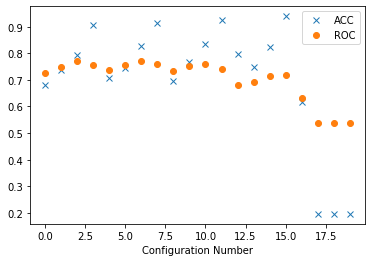

In [126]:
plt.plot(benchmarking_ab["acc"], 'x', label="ACC")
plt.plot(benchmarking_ab["roc"], 'o', label="ROC")
plt.xlabel("Configuration Number")
plt.legend()

From the plot above, the ROC is uniform in the first 16 configurations. Choosing the 7th:

In [127]:
dt_classifier = DecisionTreeClassifier(criterion='gini', splitter='best',
                           max_depth=9, min_samples_split=5,
                           min_samples_leaf=2, min_weight_fraction_leaf=0.0, 
                           max_features=None, random_state=None, 
                           max_leaf_nodes=None, min_impurity_decrease=0.0, 
                           min_impurity_split=None, class_weight='balanced')

model = AdaBoostClassifier(base_estimator=dt_classifier, n_estimators=20, learning_rate=0.9, random_state=0)

clf_ab = \
    Pipeline(steps=[('preprocessor', preprocessor),
                    ('classifier', model)])
clf_ab.fit(train,train[target])
print("Model Train Score: {0}".format(clf_ab.score(train,train[target])))
print("Model Test Score : {0}".format(clf_ab.score(test,test[target])))
print_metrics(clf_ab)

Model Train Score: 0.8366334849085656
Model Test Score : 0.826572300593593
Accuracy:   0.826572300593593
Precision:  0.10801868431296224
Recall:     0.7088122605363985
F1:         0.18746833305184935
ROC-AUC:    0.7694024825736658

Confusion Matrix
[[0.8299927  0.1700073 ]
 [0.29118774 0.70881226]]


In [130]:
coeffs_ab = {}
for idx, item in enumerate(clf_ab['classifier'].feature_importances_):
    coeffs_ab[new_cols[idx]] = item
for key in sorted(coeffs_ab,key=lambda x: abs(coeffs_ab[x]),reverse=True):
    if coeffs_ab[key]!=0:
        print("{0:40}:{1}".format(key,coeffs_ab[key]))

time_scaled                             :0.4881449666397608
Year_scaled                             :0.20637536238235166
brand_initials_toy                      :0.02486168254507272
brand_initials_hon                      :0.02445919164514302
Register Issue_scaled                   :0.020443504777023967
brand_initials_for                      :0.020331572571578617
Speed Issue_scaled                      :0.017330503022809175
brand_initials_nis                      :0.015396689058445493
brand_initials_che                      :0.015347895962393582
brand_initials_jee                      :0.015182804947127902
Stop Sign Issue_scaled                  :0.014968402914623005
Reckless Issue_scaled                   :0.012596888858080867
Car Lights Issue_scaled                 :0.01235911569497058
Drug Issue_scaled                       :0.011445034516990391
brand_initials_vol                      :0.009439020342959483
Obey Issue_scaled                       :0.008902860726797144
brand_initials

The accuracy is still similar

In [129]:
# Basic case
model = \
    BernoulliNB(alpha=0.289474)

clf_bnb = \
    Pipeline(steps=[('preprocessor', preprocessor),
                    ('classifier', model)])
clf_bnb.fit(train,train[target])
print("Model Train Score: {0}".format(clf_bnb.score(train,train[target])))
print("Model Test Score : {0}".format(clf_bnb.score(test,test[target])))
print_metrics(clf_bnb)

Model Train Score: 0.9723250748005747
Model Test Score : 0.9717622743985965
Accuracy:   0.9717622743985965
Precision:  0.0
Recall:     0.0
F1:         0.0
ROC-AUC:    0.49999381746689253

Confusion Matrix
[[9.99987635e-01 1.23650662e-05]
 [1.00000000e+00 0.00000000e+00]]


For bernoulli, there is still a bias to the Positive value

## Conclusions

The best method for this dataset is Adaboost, which is resilient enough to handle the correlation between variables, giving an accuracy of 82%. Similar performance is achieved by using Decision Trees, but with lower accuracies.

On the other hand, the variable which is strongly correlated to the accidents is the Time (hour), where the early evening is when most of the accidents happened.

In the case of the Decision Trees, it also takes some factors, such as the Registration, Lights and Drugs, whereas AdaBoost is taking other factors such as the models. 

From the performance and correctness point of view, the Decision Trees seems to be the more reasonable resultsand provides interesting information about the accident ocurrence. The AdaBoost provides also information about how the brands also influence on the accident ocurrence, but this fact should be analysed with more detail.